In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [11]:
import numpy as np
import tensorflow as tf

import scipy.stats as spt

DTYPE = tf.float64
tf.keras.backend.set_floatx('float64')

In [12]:
from vegasflow import VegasFlowPlus, VegasFlow

In [30]:
m_tf = tf.constant(0.5, dtype=tf.float64)
alpha_tf = tf.constant(0.01 * np.sqrt(2), dtype=tf.float64)
pi_tf = tf.constant(np.pi, dtype=tf.float64)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f1_d8_tf(x):
    pre = 1.0 / (alpha_tf * tf.sqrt(pi_tf)) ** 8
    exponent = -1 * tf.reduce_sum((x - m_tf) ** 2, axis=-1) / alpha_tf ** 2
    return pre * tf.exp(exponent) / 1.




norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67
sigma = 0.01
norm_dist_1 = spt.norm(loc=norm_m1, scale=sigma)
norm_dist_2 = spt.norm(loc=norm_m2, scale=sigma)
norm_dist_3 = spt.norm(loc=norm_m3, scale=sigma)

norm_triple = norm_dist_1.cdf(1) - norm_dist_1.cdf(0) \
            + norm_dist_2.cdf(1) - norm_dist_2.cdf(0) \
            + norm_dist_3.cdf(1) - norm_dist_3.cdf(0)
norm_triple /= 3

dim2target_dict = {
    2: norm_triple ** 2,
    4: norm_triple ** 4,
    6: norm_triple ** 6,
    8: norm_triple ** 8,
}

integ_bounds = [0, 1]

ms_tf = tf.constant([norm_m1, norm_m2, norm_m3], dtype=DTYPE)
alpha_tf = tf.constant(sigma * np.sqrt(2), dtype=DTYPE)
pi_tf = tf.constant(np.pi, dtype=DTYPE)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=DTYPE)])
def f2_d6_tf(x):
    pre = 1. / (alpha_tf * tf.sqrt(pi_tf)) ** 6
    exponent1 = -1. * tf.reduce_sum(((x - ms_tf[0]) ** 2), axis=-1) / alpha_tf ** 2
    exponent2 = -1. * tf.reduce_sum(((x - ms_tf[1]) ** 2), axis=-1) / alpha_tf ** 2
    exponent3 = -1. * tf.reduce_sum(((x - ms_tf[2]) ** 2), axis=-1) / alpha_tf ** 2
    res = pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))
    return res / dim2target_dict[6]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=DTYPE)])
def f2_d8_tf(x):
    pre = 1. / (alpha_tf * tf.sqrt(pi_tf)) ** 8
    exponent1 = -1. * tf.reduce_sum(((x - ms_tf[0]) ** 2), axis=-1) / alpha_tf ** 2
    exponent2 = -1. * tf.reduce_sum(((x - ms_tf[1]) ** 2), axis=-1) / alpha_tf ** 2
    exponent3 = -1. * tf.reduce_sum(((x - ms_tf[2]) ** 2), axis=-1) / alpha_tf ** 2
    res = pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))
    return res / dim2target_dict[8]


dim2target_dict = {
        # from 0 to 10
        2: 8 * np.cos(5) * np.sin(5) ** 3,    
        4: 32 * (np.cos(5) + np.cos(15)) * np.sin(5) ** 5,
        6: 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) ** 7,
        8: 128 * (np.cos(35) - np.cos(45)) * np.sin(5) ** 7,
    }

integ_bounds = [0, 10]
integ_size = integ_bounds[1] - integ_bounds[0]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f3_d2_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 2 / dim2target_dict[2]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f3_d4_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 4 / dim2target_dict[4]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f3_d6_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 6 / dim2target_dict[6]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f3_d8_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 8 / dim2target_dict[8]

In [53]:
ndims = 8
integrand = f3_d8_tf

In [54]:
vegas_integ = VegasFlowPlus(
    n_dim=ndims,
    n_events=int(2e5),
    adaptive=False,
    events_limit=int(1e5),
    verbose=True,
    list_devices=['GPU'],
)      

[WARNING] (vegasflow.vflowplus) VegasFlowPlus needs to hold all events in memory at once, setting the `events_limit` to be equal to `n_events=200000`


In [55]:
vegas_integ.compile(integrand, compilable=True)

In [56]:
print(vegas_integ.devices)

{'/device:GPU:0': True}


In [57]:
vegas_integ.run_integration(50)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: -1.275e+03 +/- 1.160e+03(took 0.51762 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: -3.824e+02 +/- 1.164e+03(took 0.20545 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: -8.310e+02 +/- 1.161e+03(took 0.20745 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1276.3832 +/- 1162.1211(took 0.21143 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 243.0342 +/- 1160.7122(took 0.21542 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: -9.474e+02 +/- 1.161e+03(took 0.23537 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 227.6873 +/- 1163.5706(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: -2.903e+02 +/- 1.163e+03(took 0.20246 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: -2.775e+02 +/- 1.163e+03(took 0.20246 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: -9.281e+02 +/- 1.163e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 10: 237.8453 +/- 1162.1262(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 11: -1.400e+03 +/- 1.161e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 12: 894.8555 +/- 1163.0546(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 13: -3.469e+02 +/- 1.161e+03(took 0.21243 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 14: 1259.8907 +/- 1160.6679(took 0.22141 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 15: -1.277e+03 +/- 1.164e+03(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 16: 1831.6731 +/- 1162.6223(took 0.28125 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 17: 724.7510 +/- 1160.9918(took 0.21143 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 18: -1.789e+02 +/- 1.160e+03(took 0.21642 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 19: -4.712e+02 +/- 1.161e+03(took 0.21143 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 20: -1.223e-01 +/- 1.161e+03(took 0.21642 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 21: 833.3851 +/- 1159.5388(took 0.21542 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 22: -2.995e+02 +/- 1.165e+03(took 0.21542 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 23: 521.8827 +/- 1164.4313(took 0.23936 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 24: 287.1038 +/- 1163.8026(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 25: 713.4841 +/- 1161.9916(took 0.29421 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 26: -1.619e+02 +/- 1.163e+03(took 0.24335 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 27: -8.525e+02 +/- 1.164e+03(took 0.21044 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 28: -1.025e+03 +/- 1.163e+03(took 0.21143 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 29: 516.8287 +/- 1166.8007(took 0.23138 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 30: 2177.4185 +/- 1164.9975(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 31: -5.208e+02 +/- 1.162e+03(took 0.23038 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 32: 1274.5052 +/- 1161.8799(took 0.20744 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 33: 1329.4645 +/- 1162.0562(took 0.20445 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 34: -7.177e+02 +/- 1.163e+03(took 0.22540 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 35: -1.293e+03 +/- 1.161e+03(took 0.22141 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 36: 165.6351 +/- 1158.6659(took 0.21642 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 37: 392.3518 +/- 1158.7666(took 0.21941 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 38: 570.3453 +/- 1162.2533(took 0.22141 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 39: 356.0975 +/- 1159.2185(took 0.22440 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 40: -8.830e+02 +/- 1.162e+03(took 0.28524 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 41: 1716.9358 +/- 1163.1117(took 0.21542 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 42: -2.852e+02 +/- 1.161e+03(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 43: -1.707e+02 +/- 1.164e+03(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 44: -7.097e+02 +/- 1.165e+03(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 45: 1290.9204 +/- 1162.9911(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 46: -9.011e+02 +/- 1.166e+03(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 47: -3.320e+02 +/- 1.163e+03(took 0.20745 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 48: -2.556e+03 +/- 1.165e+03(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 49: 641.2398 +/- 1163.7335(took 0.29820 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.4717 +/- 164.385


(3.4716964831838153, 164.38547330184971)

In [58]:
vegas_integ.run_integration(100)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 542.0137 +/- 1164.8384(took 0.46376 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: -1.158e+03 +/- 1.164e+03(took 0.20046 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: -1.856e+02 +/- 1.164e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 830.6497 +/- 1165.5319(took 0.20944 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: -5.513e+02 +/- 1.165e+03(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 904.4989 +/- 1166.4661(took 0.23238 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: -1.080e+03 +/- 1.167e+03(took 0.23338 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: -2.238e+02 +/- 1.168e+03(took 0.20545 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: 1648.8715 +/- 1166.1033(took 0.20645 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: 767.4459 +/- 1169.2412(took 0.21243 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 10: 543.4547 +/- 1168.3244(took 0.22939 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 11: 2394.5680 +/- 1168.5592(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 12: -2.907e+02 +/- 1.172e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 13: -3.239e+01 +/- 1.171e+03(took 0.24235 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 14: 525.8321 +/- 1175.7657(took 0.21842 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 15: 633.7151 +/- 1175.7730(took 0.23437 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 16: 702.6467 +/- 1179.1462(took 0.30718 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 17: -2.424e+02 +/- 1.179e+03(took 0.22540 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 18: 1516.8991 +/- 1181.6193(took 0.19947 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 19: -2.684e+02 +/- 1.187e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 20: 24.4470 +/- 1183.9262(took 0.22141 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 21: -3.042e+03 +/- 1.189e+03(took 0.20046 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 22: -2.089e+03 +/- 1.193e+03(took 0.22041 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 23: 1142.1737 +/- 1198.8993(took 0.19548 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 24: -5.754e+02 +/- 1.202e+03(took 0.21742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 25: -8.641e+02 +/- 1.208e+03(took 0.22440 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 26: -8.403e+02 +/- 1.212e+03(took 0.20246 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 27: -3.660e+02 +/- 1.216e+03(took 0.22041 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 28: 17.8044 +/- 1225.1880(took 0.22839 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 29: 527.1459 +/- 1228.7791(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 30: -2.180e+02 +/- 1.243e+03(took 0.23637 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 31: 3313.6276 +/- 1252.5889(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 32: 2170.8646 +/- 1262.0878(took 0.24235 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 33: 210.2834 +/- 1266.3161(took 0.21941 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 34: -7.321e+02 +/- 1.283e+03(took 0.25033 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 35: -3.130e+02 +/- 1.291e+03(took 0.22240 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 36: 158.7814 +/- 1308.2389(took 0.24933 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 37: -4.423e+02 +/- 1.322e+03(took 0.27227 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 38: -2.879e+03 +/- 1.333e+03(took 0.34009 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 39: -6.899e+02 +/- 1.345e+03(took 0.20046 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 40: -7.221e+02 +/- 1.366e+03(took 0.20445 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 41: -2.983e+03 +/- 1.384e+03(took 0.20645 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 42: -5.731e+03 +/- 1.398e+03(took 0.22340 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 43: 804.6892 +/- 1429.1390(took 0.20146 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 44: 1186.1767 +/- 1438.0424(took 0.21243 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 45: -2.722e+03 +/- 1.451e+03(took 0.22440 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 46: 701.8031 +/- 1482.5460(took 0.20545 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 47: 2914.7745 +/- 1509.9431(took 0.22939 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 48: -1.286e+03 +/- 1.526e+03(took 0.22141 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 49: -2.073e+03 +/- 1.562e+03(took 0.20645 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 50: -5.012e+02 +/- 1.588e+03(took 0.23637 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 51: 348.0746 +/- 1601.5426(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 52: 1046.1017 +/- 1645.9424(took 0.24235 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 53: -3.068e+02 +/- 1.663e+03(took 0.21343 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 54: 748.0428 +/- 1690.6260(took 0.22540 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 55: 1007.7062 +/- 1707.4048(took 0.22739 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 56: 1205.1944 +/- 1726.2572(took 0.22540 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 57: 1017.2941 +/- 1771.5811(took 0.24435 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 58: -1.661e+03 +/- 1.794e+03(took 0.22041 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 59: 165.4648 +/- 1821.4384(took 0.25033 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 60: -1.453e+03 +/- 1.835e+03(took 0.22739 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 61: -4.696e+02 +/- 1.868e+03(took 0.30119 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 62: 130.0649 +/- 1873.3580(took 0.20246 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 63: -3.263e+02 +/- 1.907e+03(took 0.20246 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 64: -2.925e+03 +/- 1.913e+03(took 0.20146 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 65: 992.7395 +/- 1957.2715(took 0.20944 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 66: -1.984e+02 +/- 1.965e+03(took 0.22241 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 67: 2170.0812 +/- 1988.5284(took 0.20146 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 68: -4.475e+03 +/- 2.014e+03(took 0.19947 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 69: 4373.4521 +/- 2011.2053(took 0.19847 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 70: -9.649e+02 +/- 2.034e+03(took 0.24036 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 71: -1.754e+02 +/- 2.049e+03(took 0.23537 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 72: -4.509e+01 +/- 2.082e+03(took 0.21941 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 73: -2.586e+03 +/- 2.072e+03(took 0.25033 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 74: -2.976e+03 +/- 2.086e+03(took 0.22540 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 75: 893.6826 +/- 2074.9380(took 0.24135 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 76: -1.819e+03 +/- 2.081e+03(took 0.23637 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 77: -2.002e+03 +/- 2.126e+03(took 0.31416 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 78: -1.643e+03 +/- 2.084e+03(took 0.20545 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 79: 1902.3593 +/- 2044.8128(took 0.22141 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 80: -1.429e+03 +/- 2.074e+03(took 0.21443 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 81: -4.768e+03 +/- 2.086e+03(took 0.19448 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 82: -1.631e+02 +/- 2.124e+03(took 0.22241 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 83: 2545.2053 +/- 2115.9718(took 0.20445 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 84: 2651.2777 +/- 2102.7902(took 0.20745 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 85: 1434.0293 +/- 2124.9977(took 0.23338 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 86: 321.0137 +/- 2138.5410(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 87: 747.5061 +/- 2130.4998(took 0.21941 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 88: -4.171e+03 +/- 2.133e+03(took 0.21443 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 89: 2141.7663 +/- 2083.0582(took 0.20645 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 90: 528.7928 +/- 2090.6278(took 0.22041 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 91: -6.325e+00 +/- 2.074e+03(took 0.22739 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 92: 2105.4248 +/- 2125.7385(took 0.24933 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 93: 781.0368 +/- 2075.0598(took 0.37001 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 94: -3.822e+01 +/- 2.127e+03(took 0.20645 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 95: -2.107e+03 +/- 2.117e+03(took 0.20046 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 96: -2.586e+03 +/- 2.156e+03(took 0.22340 s)
[INFO] (vegasflow.monte_carlo) Result for iteration 97: -2.020e+03 +/- 2.187e+03(took 0.19747 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 98: 97.1524 +/- 2156.4301(took 0.20844 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 99: 2252.2101 +/- 2189.2541(took 0.21343 s)
[INFO] (vegasflow.monte_carlo)  > Final results: -124.789 +/- 148.78


(-124.78863205920224, 148.7798971363533)

In [59]:
vegas_integ._n_strat

<tf.Tensor: shape=(), dtype=int32, numpy=4>

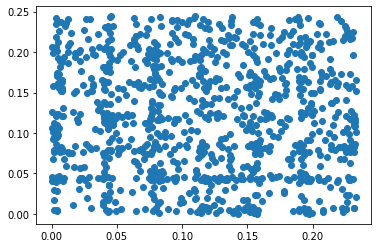

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

tt = vegas_integ._generate_random_array_plus(vegas_integ.n_events, vegas_integ.n_ev)[0].numpy()[:1000,:2]
plt.scatter(tt[:,0], tt[:,1])

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def compute_variance_weighted_result(means, sdevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert means.size == sdevs.size
    assert means.shape == sdevs.shape
    var = 1./np.sum(1./sdevs**2, axis=-1)
    mean = np.sum(means/(sdevs**2), axis=-1)
    mean *= var
    return mean, np.sqrt(var)

### LDSeq

In [6]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_LDSeq/f1_run2_fp',
    'f1_run2': 'result/06_Comp_LDSeq/f1_run3_fp',
    'f1_run3': 'result/06_Comp_LDSeq/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_LDSeq/f2_run1_fp',
    'f2_run2': 'result/06_Comp_LDSeq/f2_run2_fp',
    'f2_run3': 'result/06_Comp_LDSeq/f2_run3_fp',
    
    'f3_run1': 'result/06_Comp_LDSeq/f3_run1_fp',
    'f3_run2': 'result/06_Comp_LDSeq/f3_run2_fp',
    'f3_run3': 'result/06_Comp_LDSeq/f3_run3_fp',
    
}

In [7]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [8]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,8000000,2.233573e-33,1.908384e-33,5.240036e+32,589.177,1.771,15.407984,0.350846,2
1,f1,6,15,8000000,4.297898e-06,2.493957e-06,4.009674e+05,284.830,0.143,19.053020,0.162933,2
2,f1,4,15,8000000,1.010345e+00,7.416427e-02,1.394828e-01,180.370,0.000,4.112387,0.994751,2
3,f1,2,15,8000000,9.999976e-01,2.573552e-03,9.170684e-04,84.571,0.001,0.001425,1.000000,2
0,f1,8,15,8000000,4.799328e-29,3.517891e-29,2.842612e+28,574.607,1.451,15.280811,0.359232,3
1,f1,6,15,8000000,2.348684e-06,1.419931e-06,7.042580e+05,284.114,0.002,20.143617,0.125678,3
2,f1,4,15,8000000,9.831583e-01,7.118668e-02,2.365848e-01,179.825,0.001,1.726977,0.999966,3
3,f1,2,15,8000000,1.000033e+00,2.573643e-03,1.268688e-02,84.499,0.002,0.001515,1.000000,3
0,f1,8,15,8000000,1.233723e-36,1.095327e-36,9.129696e+35,603.118,1.427,15.679741,0.333321,4
1,f1,6,15,8000000,4.717529e-06,1.762592e-06,5.673437e+05,283.823,0.002,14.264053,0.430230,4


In [10]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'ldseq'
agg_df  #.reset_index()

res_mean                     res_err  \
                                mean           std          mean   
func ndim nitn neval                                               
f1   2    15   8000000  1.000020e+00  1.920889e-05  2.573598e-03   
     4    15   8000000  9.827032e-01  2.787171e-02  7.112798e-02   
     6    15   8000000  3.788037e-06  1.264051e-06  1.892160e-06   
     8    15   8000000  1.599851e-29  2.770829e-29  1.172694e-29   
f2   2    15   8000000  1.000002e+00  1.090654e-05  1.483957e-03   
     4    15   8000000  9.836375e-01  1.115930e-02  4.127122e-02   
     6    15   8000000  1.280414e-04  1.299131e-04  5.324295e-05   
     8    15   8000000  3.361009e-23  2.988023e-23  2.436813e-23   
f3   2    15   8000000  6.904925e-04  1.311635e-05  3.225874e-03   
     4    15   8000000  4.179247e-03  2.534981e-02  5.226239e-02   
     6    15   8000000  2.501432e-02  8.240949e-01  1.312925e+00   
     8    15   8000000 -2.874745e+01  6.019535e+01  4.733282e+01   

                                           res_rel                total_time  \
                                 std          mean           std        mean   
func ndim nitn neval                                                           
f1   2    15   8000000  4.550468e-08  8.270254e-03  6.410900e-03   84.694000   
     4    15   8000000  3.066064e-03  3.477637e-01  2.808881e-01  180.083000   
     6    15   8000000  5.486112e-07  5.575230e+05  1.518836e+05  284.255667   
     8    15   8000000  2.031000e-29  3.044979e+35  5.269520e+35  588.967333   
f2   2    15   8000000  1.035638e-08  5.067460e-03  4.416023e-03   86.668667   
     4    15   8000000  8.869933e-04  4.004393e-01  2.823121e-01  182.076333   
     6    15   8000000  5.365093e-05  6.581750e+04  8.596904e+04  284.198667   
     8    15   8000000  2.154887e-23  6.120501e+24  1.055284e+25  585.097667   
f3   2    15   8000000  1.203963e-09  3.097795e+02  4.036054e-03   84.456667   
     4    15   8000000  5.318093e-07  1.905425e+01  4.852452e-01  180.060667   
     6    15   8000000  2.602735e-05  7.426054e-01  6.276776e-01  284.278667   
     8    15   8000000  5.684809e-04  7.823557e-01  1.136547e+00  569.913667   

                                   pre_time                 chi2            \
                              std      mean       std       mean       std   
func ndim nitn neval                                                         
f1   2    15   8000000   0.277739  0.001667  0.000577   0.001282  0.000328   
     4    15   8000000   0.273655  0.001000  0.001000   3.841395  1.992790   
     6    15   8000000   0.518232  0.049000  0.081406  17.820230  3.127642   
     8    15   8000000  14.256656  1.549667  0.192056  15.456179  0.203785   
f2   2    15   8000000   0.328550  0.002000  0.000000   0.001332  0.000556   
     4    15   8000000   1.890313  0.001333  0.000577   5.210923  1.633178   
     6    15   8000000   6.544535  0.002333  0.001528  18.664018  1.129332   
     8    15   8000000   8.886828  2.341667  1.454951  16.070199  1.195444   
f3   2    15   8000000   0.468036  0.001333  0.000577   0.000749  0.000611   
     4    15   8000000   1.221525  0.002000  0.000000  12.286905  8.362698   
     6    15   8000000   0.851002  0.001667  0.001155  16.429846  5.194724   
     8    15   8000000   7.664516  1.555333  0.243430  13.338929  7.573264   

                               Q            itype  
                            mean       std         
func ndim nitn neval                               
f1   2    15   8000000  1.000000  0.000000  ldseq  
     4    15   8000000  0.989513  0.013837  ldseq  
     6    15   8000000  0.239614  0.166126  ldseq  
     8    15   8000000  0.347800  0.013222  ldseq  
f2   2    15   8000000  1.000000  0.000000  ldseq  
     4    15   8000000  0.973704  0.028391  ldseq  
     6    15   8000000  0.181289  0.047432  ldseq  
     8    15   8000000  0.312679  0.075101  ldseq  
f3   2    15   8000000  1.000000  0.000000  ldseq  
     4    1

In [100]:
means_sdevs_dict ={
    'f1_run2_d2': 'result/06_Comp_LDSeq/f1_run2_fp_d2_means_sdevs.npy',
    'f1_run2_d4': 'result/06_Comp_LDSeq/f1_run2_fp_d4_means_sdevs.npy',
    'f1_run2_d6': 'result/06_Comp_LDSeq/f1_run2_fp_d6_means_sdevs.npy',
    'f1_run2_d8': 'result/06_Comp_LDSeq/f1_run2_fp_d8_means_sdevs.npy',
    
    'f2_run2_d2': 'result/06_Comp_LDSeq/f2_run2_fp_d2_means_sdevs.npy',
    'f2_run2_d4': 'result/06_Comp_LDSeq/f2_run2_fp_d4_means_sdevs.npy',
    'f2_run2_d6': 'result/06_Comp_LDSeq/f2_run2_fp_d6_means_sdevs.npy',
    'f2_run2_d8': 'result/06_Comp_LDSeq/f2_run2_fp_d8_means_sdevs.npy',
    
    'f3_run2_d2': 'result/06_Comp_LDSeq/f3_run2_fp_d2_means_sdevs.npy',
    'f3_run2_d4': 'result/06_Comp_LDSeq/f3_run2_fp_d4_means_sdevs.npy',
    'f3_run2_d6': 'result/06_Comp_LDSeq/f3_run2_fp_d6_means_sdevs.npy',
    'f3_run2_d8': 'result/06_Comp_LDSeq/f3_run2_fp_d8_means_sdevs.npy',
    
}


stat_df = pd.DataFrame()

for k,v in means_sdevs_dict.items():
    
    func, run_num, ndim = k.split('_')
    
    arr = np.load(v)
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndim'] = int(ndim[1:])
    temp_df['run_num'] = int(run_num[3:])
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndim', 'itype', *range(15), 'run_num']]

In [101]:
stat_df

,func,ndim,itype,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,run_num
0,f1,2,mean,9.999775e-01,1.000075e+00,1.000096,9.998716e-01,1.000020e+00,9.999715e-01,1.000128e+00,1.000030e+00,1.000169e+00,9.997775e-01,9.999929e-01,9.999242e-01,1.000038e+00,9.999639e-01,9.999311e-01,2
1,f1,2,sdev,9.966589e-03,9.968393e-03,0.009969,9.966149e-03,9.967051e-03,9.967048e-03,9.968392e-03,9.967261e-03,9.969416e-03,9.965491e-03,9.966754e-03,9.966519e-03,9.967801e-03,9.967174e-03,9.966739e-03,2
0,f1,4,mean,1.084689e+00,1.103203e+00,0.926479,7.702783e-01,1.148402e+00,1.286830e+00,1.066530e+00,1.025590e+00,1.116270e+00,9.641953e-01,1.140330e+00,9.823417e-01,1.182366e+00,1.035307e+00,1.196431e+00,2
1,f1,4,sdev,2.799524e-01,2.859621e-01,0.279227,1.587191e-01,3.447102e-01,3.817759e-01,2.892980e-01,3.292764e-01,2.959155e-01,2.906209e-01,3.362080e-01,3.146379e-01,3.554606e-01,3.234400e-01,3.498986e-01,2
0,f1,6,mean,2.072744e-03,3.212079e-06,0.000021,1.822201e-04,1.723437e-04,6.402230e-05,1.079027e-02,3.424776e-03,1.227913e-03,8.627934e-05,5.075495e-02,4.643299e-02,2.490552e+01,1.983597e-03,1.345827e-03,2
1,f1,6,sdev,1.740279e-03,2.552915e-06,0.000012,1.624421e-04,1.713018e-04,4.514844e-05,7.085113e-03,3.276341e-03,1.210686e-03,8.461908e-05,3.557433e-02,4.393743e-02,2.490272e+01,1.799178e-03,1.343493e-03,2
0,f1,8,mean,2.233561e-33,3.727966e-22,0.000131,3.107651e-17,8.212852e-10,1.282859e-20,9.891405e-17,7.983237e-16,3.075247e-28,7.940779e-23,2.432686e-26,4.880929e-17,8.857813e-20,4.148685e-22,1.560868e-19,2
1,f1,8,sdev,1.908384e-33,3.727947e-22,0.000131,3.107651e-17,8.212852e-10,1.090053e-20,9.890968e-17,7.983229e-16,3.075242e-28,7.762801e-23,2.430540e-26,3.477489e-17,8.857665e-20,4.139087e-22,1.560868e-19,2
0,f2,2,mean,9.999353e-01,1.000057e+00,1.000091,9.999500e-01,1.000021e+00,1.000072e+00,1.000091e+00,9.999256e-01,1.000022e+00,1.000088e+00,1.000019e+00,9.999556e-01,9.999664e-01,1.000020e+00,1.000008e+00,2
1,f2,2,sdev,5.746819e-03,5.747431e-03,0.005748,5.746935e-03,5.747482e-03,5.747669e-03,5.747497e-03,5.747191e-03,5.747510e-03,5.747697e-03,5.747131e-03,5.747409e-03,5.747304e-03,5.747220e-03,5.747205e-03,2


In [147]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(15)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(15)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,16)]    
    # w_arr = [(x[0],y[0]) for x,y in w_arr]
#     print(w_arr)
    w_arr = np.array(w_arr).T
#     print(w_arr)
#     print('---------------------')
    return pd.concat([x[['func', 'ndim', 'itype']], pd.DataFrame(w_arr)], axis=1)

a = stat_df.groupby(['func', 'ndim'], as_index=False).apply(temp_foo).reset_index(drop=True)
a

,func,ndim,itype,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,f1,2,mean,9.999775e-01,1.000026e+00,1.000050e+00,1.000005e+00,1.000008e+00,1.000002e+00,1.000020e+00,1.000021e+00,1.000037e+00,1.000011e+00,1.000010e+00,1.000003e+00,1.000005e+00,1.000002e+00,9.999976e-01
1,f1,2,sdev,9.966589e-03,7.048081e-03,5.755045e-03,4.983780e-03,4.457583e-03,4.069170e-03,3.767373e-03,3.524043e-03,3.322571e-03,3.151997e-03,3.005291e-03,2.877325e-03,2.764454e-03,2.663891e-03,2.573552e-03
2,f1,4,mean,1.084689e+00,1.093749e+00,1.037014e+00,9.004088e-01,9.246978e-01,9.514751e-01,9.646008e-01,9.695370e-01,9.829021e-01,9.812879e-01,9.909207e-01,9.903658e-01,9.996269e-01,1.001591e+00,1.010345e+00
3,f1,4,sdev,2.799524e-01,2.000471e-01,1.626198e-01,1.135854e-01,1.078796e-01,1.038146e-01,9.771358e-02,9.367595e-02,8.930790e-02,8.536801e-02,8.274237e-02,8.002161e-02,7.806784e-02,7.588857e-02,7.416427e-02
4,f1,6,mean,2.072744e-03,3.216532e-06,3.948020e-06,3.990215e-06,4.026040e-06,4.209271e-06,4.210609e-06,4.212593e-06,4.217790e-06,4.289072e-06,4.289322e-06,4.289471e-06,4.289472e-06,4.293275e-06,4.297898e-06
5,f1,6,sdev,1.740279e-03,2.552913e-06,2.499435e-06,2.499139e-06,2.498873e-06,2.495054e-06,2.495054e-06,2.495053e-06,2.495048e-06,2.493964e-06,2.493964e-06,2.493964e-06,2.493964e-06,2.493962e-06,2.493957e-06
6,f1,8,mean,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33
7,f1,8,sdev,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33
8,f2,2,mean,9.999353e-01,9.999959e-01,1.000028e+00,1.000008e+00,1.000011e+00,1.000021e+00,1.000031e+00,1.000018e+00,1.000018e+00,1.000025e+00,1.000025e+00,1.000019e+00,1.000015e+00,1.000015e+00,1.000015e+00
9,f2,2,sdev,5.746819e-03,4.063831e-03,3.318266e-03,2.873644e-03,2.570283e-03,2.346360e-03,2.172313e-03,2.032003e-03,1.915796e-03,1.817494e-03,1.732904e-03,1.659130e-03,1.594039e-03,1.536051e-03,1.483963e-03


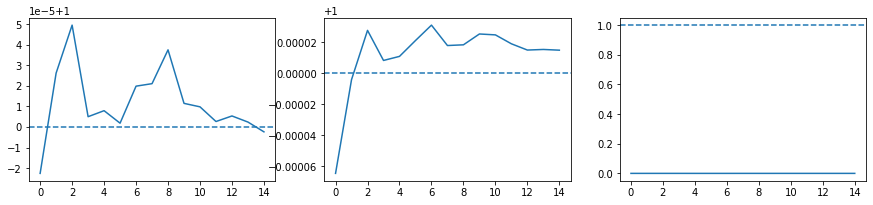

In [185]:
fig = plt.figure(figsize=(15,3))

ax = fig.add_subplot(1,3,1)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f1') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

ax = fig.add_subplot(1,3,2)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f2') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

ax = fig.add_subplot(1,3,3)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f3') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

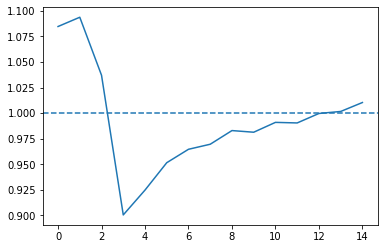

In [169]:
plt.axhline(1, linestyle='--')
plt.plot(range(15),
         a.loc[(a.func == 'f1') & (a['ndim'] == 4) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

### RSobol

#### Plot

In [167]:
temp_folder = 'result/02_LDS_RSobol_seed'

In [168]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [169]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(5,15), 'run_num']]

In [170]:
stat_df

,func,ndims,itype,5,6,7,8,9,10,11,12,13,14,run_num
0,f1,2,mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,f1,2,sdev,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,1
0,f1,4,mean,1.018281,1.443268,1.273280,1.013052,0.969743,1.238797,1.441319,0.390763,1.001222,0.894070,1
1,f1,4,sdev,0.297689,0.377154,0.305736,0.284191,0.245957,0.351513,0.346909,0.071710,0.263344,0.218056,1
0,f1,6,mean,0.000299,0.000120,0.000210,0.008290,0.000005,0.005909,0.000019,0.002915,0.001737,0.844867,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.197669,0.197667,0.197668,0.197673,0.197669,0.197669,0.197669,0.197669,0.197669,0.197669,5
0,f3,6,mean,0.047262,-0.385027,0.119248,-0.036759,0.047366,0.032574,0.171003,-0.231059,-0.198880,0.175309,5
1,f3,6,sdev,4.965644,4.965872,4.965889,4.965793,4.965723,4.965656,4.965695,4.965829,4.965520,4.965901,5
0,f3,8,mean,0.996034,453.558852,41.274205,19.694367,-121.728126,0.947683,58.081654,12.677525,29.597471,-72.679827,5


In [171]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,5,6,7,8,9,10,11,12,13,14
0,f1,2,mean,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,f1,2,sdev,9.733681e-03,9.733681e-03,9.733679e-03,9.733680e-03,9.733680e-03,9.733681e-03,9.733681e-03,9.733668e-03,9.733681e-03,9.733681e-03
2,f1,4,mean,1.018281e+00,1.443268e+00,1.273280e+00,1.013052e+00,9.697433e-01,1.238797e+00,1.441319e+00,3.907630e-01,1.001222e+00,8.940703e-01
3,f1,4,sdev,2.976890e-01,3.771545e-01,3.057355e-01,2.841909e-01,2.459567e-01,3.515132e-01,3.469088e-01,7.170950e-02,2.633442e-01,2.180558e-01
4,f1,6,mean,2.989885e-04,1.198525e-04,2.099686e-04,8.289682e-03,5.009532e-06,5.909179e-03,1.856856e-05,2.915047e-03,1.737264e-03,8.448670e-01
5,f1,6,sdev,2.243732e-04,8.057512e-05,2.090822e-04,8.289411e-03,3.492469e-06,5.626895e-03,1.840972e-05,2.915031e-03,1.639654e-03,8.206029e-01
6,f1,8,mean,2.193037e-18,9.961433e-25,7.917435e-10,3.185917e-13,8.269180e-12,1.794489e-18,1.565502e-17,1.342574e-26,1.563028e-06,4.099200e-26
7,f1,8,sdev,2.143945e-18,9.945494e-25,7.917435e-10,3.185911e-13,8.261880e-12,1.794487e-18,1.539803e-17,1.027449e-26,1.562786e-06,4.099199e-26
8,f2,2,mean,1.000000e+00,9.999996e-01,9.999998e-01,9.999999e-01,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999993e-01,1.000002e+00
9,f2,2,sdev,5.612667e-03,5.612663e-03,5.612667e-03,5.612668e-03,5.612668e-03,5.612674e-03,5.612669e-03,5.612662e-03,5.612670e-03,5.612709e-03


In [172]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(5,15)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(5,15)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

a = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
a

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,f1,2,sdev,9.733681e-03,6.882752e-03,5.619743e-03,4.866840e-03,4.353034e-03,3.973758e-03,3.678985e-03,3.441375e-03,3.244560e-03,3.078060e-03
2,f1,4,mean,1.018281e+00,1.181415e+00,1.215289e+00,1.154797e+00,1.101987e+00,1.118758e+00,1.154819e+00,6.020401e-01,6.223641e-01,6.411460e-01
3,f1,4,sdev,2.976890e-01,2.336704e-01,1.856552e-01,1.554283e-01,1.313919e-01,1.230750e-01,1.159915e-01,6.099439e-02,5.942137e-02,5.733081e-02
4,f1,6,mean,2.989885e-04,1.403152e-04,1.484129e-04,1.490149e-04,5.354346e-06,5.356615e-06,5.814522e-06,5.818543e-06,5.826108e-06,5.826123e-06
5,f1,6,sdev,2.243732e-04,7.583355e-05,7.128935e-05,7.128671e-05,3.488285e-06,3.488284e-06,3.427302e-06,3.427300e-06,3.427292e-06,3.427292e-06
6,f1,8,mean,2.193037e-18,9.961438e-25,9.961438e-25,9.961438e-25,9.961438e-25,9.961443e-25,9.961444e-25,1.353061e-26,1.353061e-26,1.515369e-26
7,f1,8,sdev,2.143945e-18,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,1.027394e-26,1.027394e-26,9.965700e-27
8,f2,2,mean,1.000000e+00,9.999998e-01,9.999998e-01,9.999998e-01,9.999998e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000e+00
9,f2,2,sdev,5.612667e-03,3.968753e-03,3.240474e-03,2.806333e-03,2.510061e-03,2.291362e-03,2.121389e-03,1.984378e-03,1.870889e-03,1.774883e-03


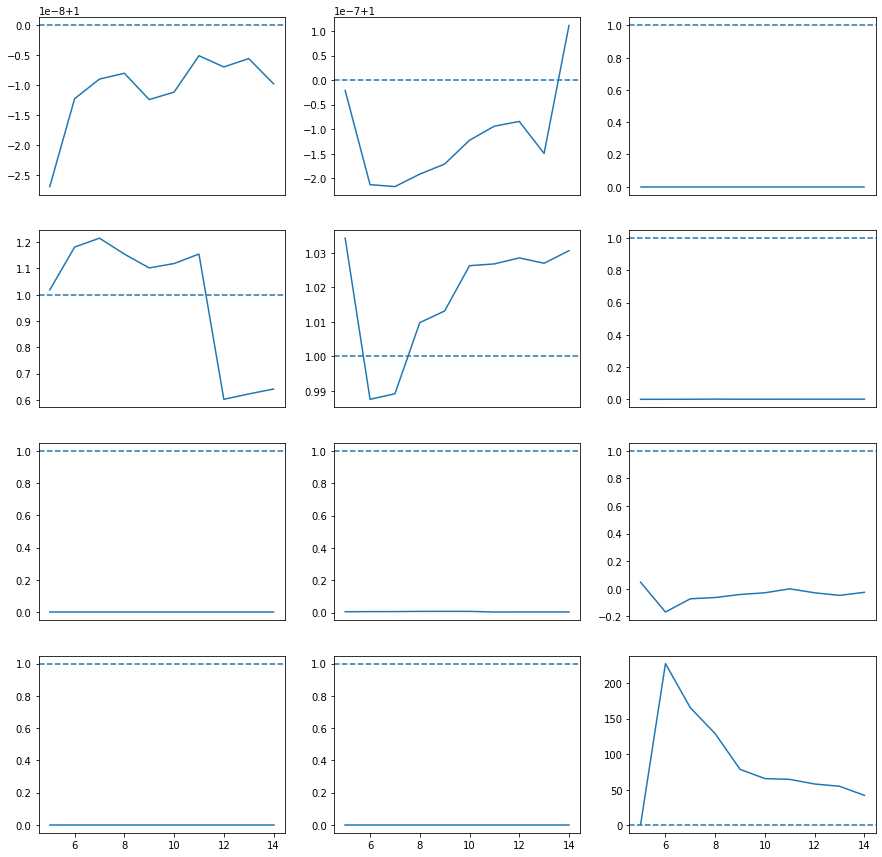

In [173]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = a.loc[(a.func == func) & (a['ndims'] == ndims) & (a['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='sobol')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### Vegas

In [11]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_Vegas/f1_run2_fp',
    'f1_run2': 'result/06_Comp_Vegas/f1_run3_fp',
    'f1_run3': 'result/06_Comp_Vegas/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_Vegas/f2_run1_fp',
    'f2_run2': 'result/06_Comp_Vegas/f2_run2_fp',
    'f2_run3': 'result/06_Comp_Vegas/f2_run3_fp',
    
    'f3_run1': 'result/06_Comp_Vegas/f3_run1_fp',
    'f3_run2': 'result/06_Comp_Vegas/f3_run2_fp',
    'f3_run3': 'result/06_Comp_Vegas/f3_run3_fp',
}

In [12]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [13]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,ncall,avg_neval,chi2,Q,run_num
0,f1,8,15,10000000,1.000030,0.000100,0.303503,57.945,19.551,3450,8547187.0,3.644498,0.933216,2
1,f1,6,15,10000000,0.999895,0.000068,1.537026,46.483,15.353,3465,8558940.5,5.044093,0.830448,2
2,f1,4,15,10000000,1.000051,0.000043,1.187420,37.082,12.960,3765,9002218.7,8.887863,0.447689,2
3,f1,2,15,10000000,1.000000,0.000003,0.128476,15.974,5.678,3630,4805000.0,4.784969,0.852636,2
0,f1,8,15,10000000,0.999867,0.000101,1.322553,58.797,20.316,3450,8560329.4,12.633296,0.179913,3
1,f1,6,15,10000000,0.999962,0.000068,0.551754,46.269,15.422,3465,8558567.4,4.549061,0.871715,3
2,f1,4,15,10000000,1.000011,0.000043,0.252019,38.028,13.285,3765,9000613.1,3.640003,0.933471,3
3,f1,2,15,10000000,0.999999,0.000003,0.297437,15.932,5.671,3630,4805000.0,11.773117,0.226404,3
0,f1,8,15,10000000,0.999895,0.000103,1.023041,57.953,19.632,3450,8566756.2,15.505813,0.077947,4
1,f1,6,15,10000000,1.000049,0.000067,0.735727,47.146,16.112,3465,8559926.4,3.283802,0.951973,4


In [14]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vegas'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   10000000   1.000001   0.000003   0.000003  2.456489e-08   
     4    15   10000000   1.000013   0.000036   0.000043  2.954028e-07   
     6    15   10000000   0.999969   0.000077   0.000068  6.004292e-07   
     8    15   10000000   0.999931   0.000088   0.000101  1.162594e-06   
f2   2    15   10000000   0.999986   0.000012   0.000010  2.920957e-08   
     4    15   10000000   0.999925   0.000091   0.000252  6.695792e-06   
     6    15   10000000   0.889028   0.192607   0.000790  4.832890e-04   
     8    15   10000000   0.333342   0.000013   0.000035  1.086584e-06   
f3   2    15   10000000   0.999988   0.000018   0.000013  1.700933e-09   
     4    15   10000000   0.997878   0.006881   0.008477  9.665685e-07   
     6    15   10000000   1.272669   1.062577   0.882119  5.567553e-05   
     8    15   10000000  39.347734  28.999087  53.019654  4.902356e-03   

                              res_rel             total_time            \
                                 mean         std       mean       std   
func ndim nitn neval                                                     
f1   2    15   10000000      0.601157    0.677669  15.943667  0.026502   
     4    15   10000000      0.651093    0.482569  37.354000  0.587309   
     6    15   10000000      0.941502    0.523877  46.632667  0.457255   
     8    15   10000000      0.883033    0.523753  58.231667  0.489609   
f2   2    15   10000000      1.403785    1.182346  17.251000  0.039509   
     4    15   10000000      0.369649    0.234986  42.933333  0.037072   
     6    15   10000000    447.472247  773.771131  54.919000  0.658542   
     8    15   10000000  19184.790581  589.881363  61.554000  0.565851   
f3   2    15   10000000      1.331889    0.540823  16.000000  0.019519   
     4    15   10000000      0.706580    0.064273  35.436667  0.052501   
     6    15   10000000      1.004341    0.285150  45.522000  0.177857   
     8    15   10000000      0.723243    0.546859  59.400667  0.109464   

                          pre_time             ncall          avg_neval  \
                              mean       std    mean  std          mean   
func ndim nitn neval                                                      
f1   2    15   10000000   5.671667  0.006028  3630.0  0.0  4.805000e+06   
     4    15   10000000  13.064667  0.190894  3765.0  0.0  9.001820e+06   
     6    15   10000000  15.629000  0.419711  3465.0  0.0  8.559145e+06   
     8    15   10000000  19.833000  0.420246  3450.0  0.0  8.558091e+06   
f2   2    15   10000000   6.247333  0.009292  3630.0  0.0  4.805000e+06   
     4    15   10000000  14.601333  0.029143  3765.0  0.0  9.956351e+06   
     6    15   10000000  17.379333  0.345544  3465.0  0.0  9.582406e+06   
     8    15   10000000  20.847667  0.403267  3450.0  0.0  8.590365e+06   
f3   2    15   10000000   5.748667  0.009609  3630.0  0.0  4.805000e+06   
     4    15   10000000  11.963333  0.002082  3765.0  0.0  8.797914e+06   
     6    15   10000000  15.293667  0.040808  3465.0  0.0  8.470418e+06   
     8    15   10000000  20.028667  0.310775  3450.0  0.0  8.435914e+06   

                                            chi2                   Q  \
                                  std       mean       std      mean   
func ndim nitn neval                                                   
f1   2    15   10000000      0.000000   6.609799  4.535161  0.677200   
     4    15   10000000   1064.692633   8.499859  4.677939  0.515017   
     6    15   10000000    702.149488   4.292319  0.907796  0.884712   
     8    15   10000000   9974.801791  10.594536  6.187900  0.397025   
f2   2    15   10000000      0.000000   6.659667  1.243737  0.670089   
     4    15   10000000     66.645555   9.843443  3.294961  0.403740   
     6    15   10000000  20239

#### Plot

In [174]:
temp_folder = 'result/06_Comp_Vegas'

In [175]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [176]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [177]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000003,1.000019,0.999939,1.000084,0.999952,1.000103,1.000034,1.000001,1.000128,1.000005,1
1,f1,2,sdev,0.000003,0.000017,0.000040,0.000070,0.000083,0.000099,0.000101,0.000104,0.000109,0.000087,1
0,f1,4,mean,1.000071,0.999962,1.000031,1.000341,0.999966,1.000033,1.000130,1.000296,0.999901,1.000205,1
1,f1,4,sdev,0.000075,0.000088,0.000123,0.000168,0.000192,0.000214,0.000234,0.000207,0.000180,0.000194,1
0,f1,6,mean,1.000041,1.000031,0.999983,0.999678,0.999932,1.000160,1.000363,0.999904,1.000627,0.999900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.026815,0.026798,0.026809,0.026813,0.026804,0.026802,0.026799,0.026797,0.026805,0.026815,5
0,f3,6,mean,-2.268653,5.213461,0.669581,-7.435592,1.171762,-1.874606,0.625243,1.793838,0.599039,2.632898,5
1,f3,6,sdev,2.789910,2.787149,2.788402,2.787724,2.790096,2.790574,2.790156,2.789828,2.788378,2.788342,5
0,f3,8,mean,432.597823,31.133712,11.680626,-115.835583,65.915727,55.775956,-61.228676,-27.161943,148.841048,-241.620662,5


In [178]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000,0.999998,0.999982,1.000025,0.999967,1.000057,0.999930,0.999954,0.999988,1.000031
1,f1,2,sdev,0.000003,0.000017,0.000042,0.000067,0.000085,0.000097,0.000101,0.000106,0.000103,0.000080
2,f1,4,mean,1.000035,0.999945,1.000019,1.000145,0.999923,0.999930,1.000098,0.999994,1.000006,1.000177
3,f1,4,sdev,0.000075,0.000088,0.000124,0.000168,0.000193,0.000216,0.000228,0.000215,0.000200,0.000205
4,f1,6,mean,1.000104,1.000000,1.000002,0.999967,0.999980,1.000079,0.999938,0.999907,1.000024,0.999881
5,f1,6,sdev,0.000186,0.000176,0.000184,0.000202,0.000220,0.000236,0.000245,0.000254,0.000251,0.000255
6,f1,8,mean,0.999949,1.000099,1.000162,0.999893,1.000034,0.999979,0.999722,1.000075,1.000086,1.000138
7,f1,8,sdev,0.000428,0.000321,0.000283,0.000278,0.000292,0.000310,0.000323,0.000336,0.000340,0.000339
8,f2,2,mean,0.999990,0.999985,0.999990,0.999967,0.999955,0.999938,1.000085,0.999874,0.999983,0.999962
9,f2,2,sdev,0.000011,0.000030,0.000060,0.000090,0.000115,0.000132,0.000142,0.000143,0.000151,0.000137


In [179]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

b = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
b

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,f1,2,sdev,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
2,f1,4,mean,1.000035,0.999997,1.000001,1.000014,1.000008,1.000004,1.000008,1.000007,1.000007,1.000015
3,f1,4,sdev,0.000075,0.000057,0.000052,0.000050,0.000048,0.000047,0.000046,0.000045,0.000044,0.000043
4,f1,6,mean,1.000104,1.000049,1.000034,1.000020,1.000014,1.000021,1.000013,1.000004,1.000006,0.999997
5,f1,6,sdev,0.000186,0.000128,0.000105,0.000093,0.000086,0.000081,0.000077,0.000073,0.000070,0.000068
6,f1,8,mean,0.999949,1.000045,1.000098,1.000033,1.000033,1.000024,0.999984,0.999994,1.000003,1.000015
7,f1,8,sdev,0.000428,0.000257,0.000190,0.000157,0.000138,0.000126,0.000118,0.000111,0.000105,0.000101
8,f2,2,mean,0.999990,0.999990,0.999990,0.999990,0.999989,0.999989,0.999989,0.999989,0.999989,0.999989
9,f2,2,sdev,0.000011,0.000011,0.000011,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010


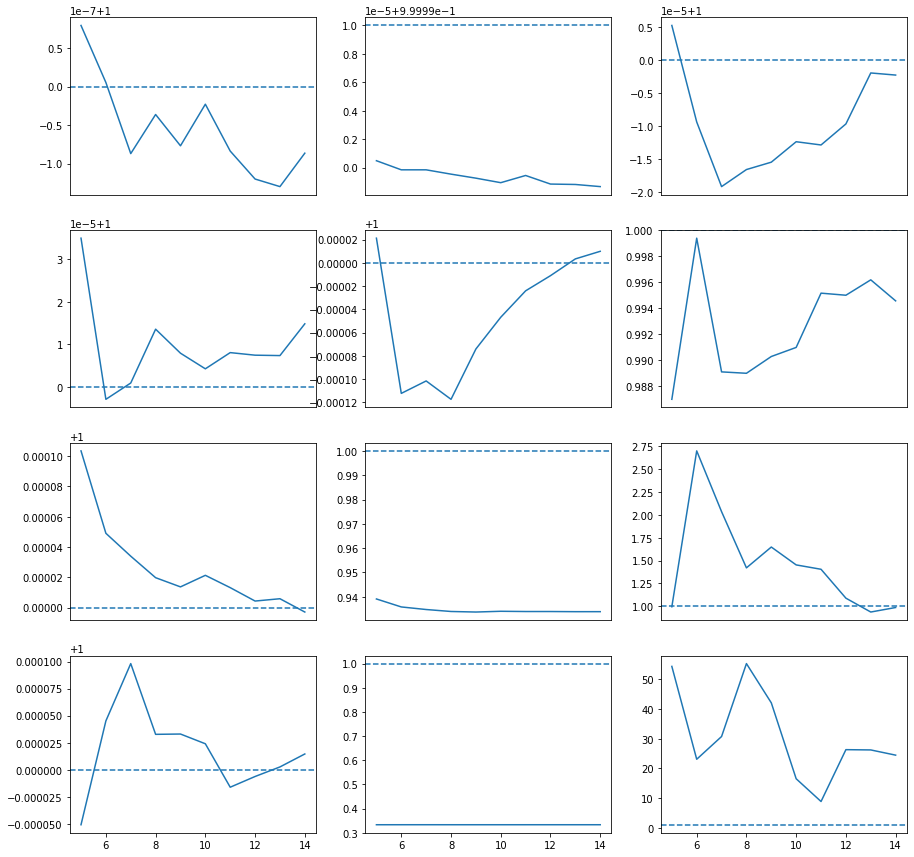

In [180]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = b.loc[(b.func == func) & (b['ndims'] == ndims) & (b['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vegas')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VegasFinalNoASS

In [26]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VegasNoASS/f1_run1_fp.csv',
    'f1_run2': 'result/06_Comp_VegasNoASS/f1_run2_fp.csv',
    'f1_run3': 'result/06_Comp_VegasNoASS/f1_run3_fp.csv',
        
    'f2_run1': 'result/06_Comp_VegasNoASS/f2_run1_fp.csv',
    'f2_run2': 'result/06_Comp_VegasNoASS/f2_run2_fp.csv',
    'f2_run3': 'result/06_Comp_VegasNoASS/f2_run3_fp.csv',
    
    'f3_run1': 'result/06_Comp_VegasNoASS/f3_run1_fp.csv',
    'f3_run2': 'result/06_Comp_VegasNoASS/f3_run2_fp.csv',
    'f3_run3': 'result/06_Comp_VegasNoASS/f3_run3_fp.csv',
}

In [27]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [28]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,ncall,avg_neval,chi2,Q,run_num
0,f1,8,15,10000000,1.000069,0.000090,0.769070,73.043,24.505,7440,9882516.0,13.974882,0.123222,1
1,f1,6,15,10000000,1.000042,0.000064,0.655316,55.187,18.187,7260,9653618.0,8.268719,0.507309,1
2,f1,4,15,10000000,0.999979,0.000028,0.735670,42.452,14.018,7500,9967008.0,14.109758,0.118474,1
3,f1,2,15,10000000,1.000002,0.000002,0.896664,28.613,9.539,7275,9680000.0,12.926223,0.165973,1
0,f1,8,15,10000000,0.999844,0.000091,1.719078,73.277,24.554,7440,9882516.0,10.635957,0.301490,2
1,f1,6,15,10000000,0.999958,0.000066,0.644640,54.944,18.125,7260,9653618.0,3.466007,0.942929,2
2,f1,4,15,10000000,1.000037,0.000027,1.335927,41.851,13.818,7500,9967008.0,13.702625,0.133304,2
3,f1,2,15,10000000,0.999999,0.000002,0.588882,28.061,9.361,7275,9680000.0,13.368987,0.146608,2
0,f1,8,15,10000000,0.999980,0.000085,0.231365,72.960,24.516,7440,9882516.0,4.375706,0.884992,3
1,f1,6,15,10000000,1.000070,0.000064,1.093210,55.244,18.211,7260,9653618.0,8.321401,0.502109,3


In [29]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vegas'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   10000000   1.000001   0.000001   0.000002  3.344985e-09   
     4    15   10000000   1.000012   0.000029   0.000028  2.669622e-07   
     6    15   10000000   1.000023   0.000059   0.000065  9.890987e-07   
     8    15   10000000   0.999964   0.000114   0.000089  3.061259e-06   
f2   2    15   10000000   1.000005   0.000005   0.000006  1.546181e-09   
     4    15   10000000   1.000013   0.000837   0.000331  3.945596e-06   
     6    15   10000000   0.998011   0.003106   0.002567  1.207190e-04   
     8    15   10000000   0.333321   0.000065   0.000030  4.949486e-07   
f3   2    15   10000000   1.000000   0.000008   0.000007  8.910492e-10   
     4    15   10000000   0.994586   0.007612   0.006982  7.791759e-07   
     6    15   10000000   1.126410   1.122473   0.742391  8.086369e-05   
     8    15   10000000  49.232465  15.775137  45.620049  4.836007e-03   

                              res_rel             total_time            \
                                 mean         std       mean       std   
func ndim nitn neval                                                     
f1   2    15   10000000      0.741370    0.153910  28.446000  0.334393   
     4    15   10000000      0.914432    0.366423  42.148667  0.300540   
     6    15   10000000      0.797722    0.255956  55.125000  0.159320   
     8    15   10000000      0.906505    0.753319  73.093333  0.164385   
f2   2    15   10000000      0.959299    0.690072  30.415333  0.317462   
     4    15   10000000      1.851737    1.163870  47.003333  0.325334   
     6    15   10000000      1.018833    0.790312  59.731333  0.524286   
     8    15   10000000  22520.654094  379.503762  75.383000  0.194515   
f3   2    15   10000000      0.918228    0.418940  28.274333  0.176211   
     4    15   10000000      0.907666    0.924320  42.030333  0.276200   
     6    15   10000000      1.101909    0.712938  55.239000  0.139753   
     8    15   10000000      1.057240    0.345703  73.111667  0.185325   

                          pre_time             ncall       avg_neval       \
                              mean       std    mean  std       mean  std   
func ndim nitn neval                                                        
f1   2    15   10000000   9.480667  0.103645  7275.0  0.0  9680000.0  0.0   
     4    15   10000000  13.918000  0.100000  7500.0  0.0  9967008.0  0.0   
     6    15   10000000  18.174333  0.044377  7260.0  0.0  9653618.0  0.0   
     8    15   10000000  24.525000  0.025710  7440.0  0.0  9882516.0  0.0   
f2   2    15   10000000  10.287000  0.101533  7275.0  0.0  9680000.0  0.0   
     4    15   10000000  15.443333  0.098475  7500.0  0.0  9967008.0  0.0   
     6    15   10000000  19.411000  0.195977  7260.0  0.0  9653618.0  0.0   
     8    15   10000000  25.275667  0.056959  7440.0  0.0  9882516.0  0.0   
f3   2    15   10000000   9.428667  0.063721  7275.0  0.0  9680000.0  0.0   
     4    15   10000000  14.026000  0.084540  7500.0  0.0  9967008.0  0.0   
     6    15   10000000  18.355333  0.077655  7260.0  0.0  9653618.0  0.0   
     8    15   10000000  24.856667  0.049602  7440.0  0.0  9882516.0  0.0   

                              chi2                   Q            itype  
                              mean       std      mean       std         
func ndim nitn neval                                                     
f1   2    15   10000000  11.345696  3.128839  0.290978  0.233487  vegas  
     4    15   10000000  13.475638  0.773025  0.144205  0.032580  vegas  
     6    15   10000000   6.685376  2.788180  0.650783  0.253020  vegas  
     8    15   10000000   9.662182  4.873112  0.436568  0.398445  vegas  
f2   2    15   10000000   8.254560  6.639805  0.597772  0.465010  vegas  
     4    15   10000000   8.129936  4.019918  0.524478  

#### Plot

In [30]:
temp_folder = 'result/06_Comp_VegasNoASS'

In [31]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [32]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [33]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000002,0.999988,1.000005,1.000083,0.999958,0.999870,1.000060,1.000003,0.999967,0.999972,1
1,f1,2,sdev,0.000002,0.000010,0.000026,0.000041,0.000051,0.000058,0.000064,0.000065,0.000066,0.000068,1
0,f1,4,mean,0.999927,1.000019,1.000158,0.999940,1.000081,1.000066,0.999681,0.999811,0.999867,1.000167,1
1,f1,4,sdev,0.000045,0.000058,0.000084,0.000112,0.000139,0.000146,0.000154,0.000154,0.000164,0.000162,1
0,f1,6,mean,0.999992,1.000065,1.000234,0.999801,1.000340,1.000157,0.999659,0.999926,0.999813,1.000370,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.022075,0.022076,0.022071,0.022077,0.022089,0.022075,0.022082,0.022079,0.022085,0.022088,3
0,f3,6,mean,-0.468116,2.418106,2.310402,-0.369678,5.772954,-1.233052,-1.378226,-2.245781,0.974856,-2.033481,3
1,f3,6,sdev,2.347088,2.348552,2.350023,2.348367,2.347311,2.347426,2.348417,2.347788,2.345837,2.348458,3
0,f3,8,mean,258.027681,66.039962,-116.301695,-278.707312,-185.767731,417.114857,-98.499717,412.783529,80.316197,16.702117,3


In [34]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000001,0.999994,1.000004,1.000073,1.000036,0.999977,1.000036,1.000045,0.999963,1.000032
1,f1,2,sdev,0.000002,0.000010,0.000026,0.000041,0.000052,0.000059,0.000063,0.000064,0.000061,0.000056
2,f1,4,mean,0.999997,1.000002,1.000072,1.000028,1.000004,1.000150,0.999970,1.000002,1.000076,0.999849
3,f1,4,sdev,0.000044,0.000057,0.000083,0.000112,0.000135,0.000149,0.000154,0.000157,0.000167,0.000168
4,f1,6,mean,1.000057,1.000036,1.000007,0.999845,1.000136,1.000166,0.999829,0.999994,1.000046,1.000080
5,f1,6,sdev,0.000133,0.000150,0.000180,0.000215,0.000245,0.000263,0.000275,0.000273,0.000273,0.000276
6,f1,8,mean,0.999770,1.000014,1.000081,1.000087,0.999530,1.000098,0.999946,0.999987,1.000036,1.000079
7,f1,8,sdev,0.000392,0.000287,0.000248,0.000243,0.000257,0.000277,0.000286,0.000293,0.000299,0.000298
8,f2,2,mean,1.000004,1.000003,1.000025,1.000009,0.999987,0.999958,1.000021,1.000051,0.999984,1.000039
9,f2,2,sdev,0.000006,0.000017,0.000034,0.000050,0.000063,0.000074,0.000078,0.000081,0.000078,0.000082


In [35]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

b = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
b

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000001,1.000000,1.000000,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001,1.000001
1,f1,2,sdev,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,f1,4,mean,0.999997,0.999999,1.000010,1.000011,1.000011,1.000016,1.000015,1.000014,1.000016,1.000011
3,f1,4,sdev,0.000044,0.000035,0.000032,0.000031,0.000030,0.000030,0.000029,0.000029,0.000028,0.000028
4,f1,6,mean,1.000057,1.000048,1.000038,1.000011,1.000023,1.000034,1.000021,1.000019,1.000021,1.000024
5,f1,6,sdev,0.000133,0.000099,0.000087,0.000081,0.000077,0.000074,0.000071,0.000069,0.000067,0.000065
6,f1,8,mean,0.999770,0.999929,1.000000,1.000028,0.999915,0.999945,0.999945,0.999950,0.999958,0.999969
7,f1,8,sdev,0.000392,0.000232,0.000169,0.000139,0.000122,0.000112,0.000104,0.000098,0.000093,0.000089
8,f2,2,mean,1.000004,1.000004,1.000005,1.000005,1.000005,1.000004,1.000005,1.000005,1.000005,1.000005
9,f2,2,sdev,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


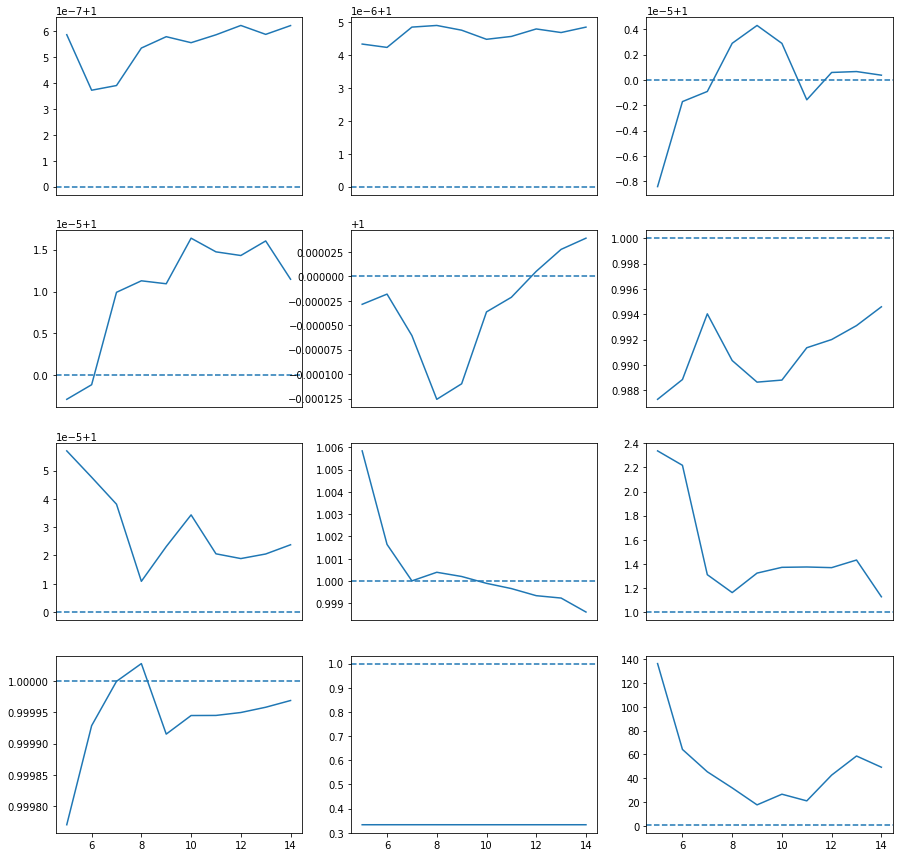

In [36]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = b.loc[(b.func == func) & (b['ndims'] == ndims) & (b['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vegas')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VFlow

In [255]:
# temp_arr = np.load('result/06_Comp_VFlow/f1_run2_fp_d8_means_sdevs.npy')
# compute_variance_weighted_result(temp_arr[0][2:], temp_arr[1][2:])

In [241]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VFlow/f1_run2_fp',
    'f1_run2': 'result/06_Comp_VFlow/f1_run3_fp',
    'f1_run3': 'result/06_Comp_VFlow/f1_run4_fp',
    'f1_run4': 'result/06_Comp_VFlow/f1_run5_fp',
        
    'f2_run1': 'result/06_Comp_VFlow/f2_run1_fp',
    'f2_run2': 'result/06_Comp_VFlow/f2_run2_fp',
    'f2_run3': 'result/06_Comp_VFlow/f2_run3_fp',
    'f2_run4': 'result/06_Comp_VFlow/f2_run4_fp',
    'f2_run5': 'result/06_Comp_VFlow/f2_run5_fp',
    
    'f3_run1': 'result/06_Comp_VFlow/f3_run1_fp',
    'f3_run2': 'result/06_Comp_VFlow/f3_run2_fp',
    'f3_run3': 'result/06_Comp_VFlow/f3_run3_fp',
    'f3_run4': 'result/06_Comp_VFlow/f3_run4_fp',
    'f3_run5': 'result/06_Comp_VFlow/f3_run5_fp',
}

In [242]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [243]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,10000000,2.247575e-11,2.149865e-11,4.651454e+10,155.955,53.635,3.511376e+07,0.000000,2
1,f1,6,15,10000000,9.998936e-01,7.624192e-05,1.395887e+00,115.598,38.837,9.851714e+00,0.362623,2
2,f1,4,15,10000000,9.999645e-01,5.794855e-05,6.128089e-01,79.671,26.558,6.537432e+00,0.685155,2
3,f1,2,15,10000000,9.999758e-01,3.948745e-05,6.130097e-01,42.394,14.124,9.525017e+00,0.390286,2
0,f1,8,15,10000000,9.999775e-01,1.048145e-04,2.145045e-01,155.163,53.400,6.574065e+00,0.681369,3
1,f1,6,15,10000000,9.999879e-01,7.536325e-05,1.599868e-01,115.072,38.427,6.289548e+00,0.710626,3
2,f1,4,15,10000000,1.000060e+00,5.793940e-05,1.043324e+00,79.682,26.655,1.249291e+00,0.998615,3
3,f1,2,15,10000000,9.999460e-01,3.948237e-05,1.368850e+00,42.339,14.202,4.667881e+00,0.862246,3
0,f1,8,15,10000000,1.000033e+00,1.303123e-04,2.553405e-01,155.592,53.472,7.445985e+00,0.590790,4
1,f1,6,15,10000000,9.999650e-01,7.495962e-05,4.665175e-01,115.578,38.569,9.348510e+00,0.405745,4


In [244]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                             mean        std       mean           std   
func ndim nitn neval                                                    
f1   2    15   10000000  0.999966   0.000030   0.000039  7.938279e-09   
     4    15   10000000  1.000025   0.000047   0.000058  9.448398e-09   
     6    15   10000000  0.999966   0.000053   0.000075  5.624837e-07   
     8    15   10000000  0.500003   0.577353   0.000059  6.866884e-05   
f2   2    15   10000000  1.000003   0.000214   0.000181  1.736280e-08   
     4    15   10000000  0.999479   0.000666   0.000731  7.815746e-07   
     6    15   10000000  0.867145   0.182802   0.001890  1.202225e-03   
     8    15   10000000  0.333317   0.000021   0.000038  4.397568e-06   
f3   2    15   10000000  0.997857   0.003064   0.003529  1.162281e-07   
     4    15   10000000  0.989146   0.032865   0.057251  1.561047e-06   
     6    15   10000000  0.184364   1.872581   1.438232  4.562427e-05   
     8    15   10000000 -0.640728  33.422988  51.850602  1.314786e-03   

                              res_rel               total_time            \
                                 mean           std       mean       std   
func ndim nitn neval                                                       
f1   2    15   10000000  9.082636e-01  6.889537e-01   42.47125  0.170171   
     4    15   10000000  7.322757e-01  4.243654e-01   79.69375  0.054586   
     6    15   10000000  5.690090e-01  5.659757e-01  115.44600  0.250668   
     8    15   10000000  2.094118e+24  4.188237e+24  155.47925  0.371118   
f2   2    15   10000000  9.939582e-01  4.171095e-01   45.05520  0.248912   
     4    15   10000000  7.728891e-01  8.490039e-01   83.28820  0.553484   
     6    15   10000000  2.319567e+02  3.170010e+02  120.02680  0.351737   
     8    15   10000000  1.765367e+04  1.796362e+03  161.61880  0.433624   
f3   2    15   10000000  7.486197e-01  7.173069e-01   42.45620  0.158339   
     4    15   10000000  5.332808e-01  1.377096e-01   79.76660  0.209873   
     6    15   10000000  1.170058e+00  6.212191e-01  115.68560  0.376084   
     8    15   10000000  4.808497e-01  3.574107e-01  155.32260  0.658852   

                         pre_time                    chi2                \
                             mean       std          mean           std   
func ndim nitn neval                                                      
f1   2    15   10000000  14.19900  0.072833  6.670564e+00  2.043532e+00   
     4    15   10000000  26.56675  0.060890  1.145107e+01  9.163302e+00   
     6    15   10000000  38.56975  0.188957  1.027166e+01  3.883455e+00   
     8    15   10000000  53.45300  0.139281  1.145411e+07  1.656036e+07   
f2   2    15   10000000  15.04800  0.094512  6.891755e+00  7.382121e-01   
     4    15   10000000  27.84380  0.222669  1.019023e+01  4.903904e+00   
     6    15   10000000  40.08600  0.150766  6.716643e+00  4.667587e+00   
     8    15   10000000  55.65200  0.267880  1.284667e+01  1.498797e+01   
f3   2    15   10000000  14.19660  0.077581  9.454898e+00  5.348327e+00   
     4    15   10000000  26.67000  0.081557  9.039667e+00  2.848394e+00   
     6    15   10000000  38.69280  0.284875  9.805349e+00  2.258999e+00   
     8    15   10000000  53.46340  0.146097  8.835976e+00  5.319004e+00   

                                Q            itype  
                             mean       std         
func ndim nitn neval                                
f1   2    15   10000000  0.670729  0.199458  vflow  
     4    15   10000000  0.436746  0.485269  vflow  
     6    15   10000000  0.388697  0.259819  vflow  
     8    15   10000000  0.318040  0.369098  vflow  
f2   2    15   10000000  0.648164  0.076144  vflow  
     4    15   10000000  0.423807  0.321588  vflow  
     6    15   10000000  0.657411  0.388226  vflow  
     8    15   10000000  0.567857  0.401713  vflow  
f3   2    15   10000000  0.488743  0.346989  vflow  
     4    15   10000000  0

#### Plot

In [181]:
temp_folder = 'result/06_Comp_VFlow'

In [182]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run2_fp_d2_means_sdevs.npy'

In [183]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [184]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000277,0.999856,0.999983,1.000046,0.999768,1.000049,1.000007,1.000114,0.999873,0.999923,2
1,f1,2,sdev,0.000194,0.000155,0.000133,0.000121,0.000115,0.000113,0.000113,0.000116,0.000118,0.000120,2
0,f1,4,mean,1.000232,0.999665,0.999975,0.999924,0.999849,0.999845,0.999934,1.000128,1.000210,0.999947,2
1,f1,4,sdev,0.000296,0.000230,0.000195,0.000176,0.000167,0.000165,0.000166,0.000169,0.000174,0.000177,2
0,f1,6,mean,1.000053,1.000041,0.999449,1.000360,1.000120,0.999814,0.999832,0.999671,0.999922,0.999776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.181056,0.181004,0.181022,0.181080,0.181061,0.181058,0.181082,0.181045,0.181040,0.181054,5
0,f3,6,mean,4.354109,-1.217511,9.251981,6.188305,-2.369796,-0.599532,-2.417781,-6.440341,3.267846,4.565051,5
1,f3,6,sdev,4.546918,4.548074,4.548415,4.547129,4.547617,4.547266,4.548752,4.548396,4.548030,4.547988,5
0,f3,8,mean,19.921791,50.405883,-297.491288,50.594629,297.164044,-111.931774,-0.135157,-171.407077,149.554789,113.132514,5


In [185]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,0.999984,0.999842,1.000049,0.999934,0.999933,0.999943,1.000011,1.000033,0.999933,0.999970
1,f1,2,sdev,0.000194,0.000155,0.000133,0.000121,0.000115,0.000113,0.000113,0.000116,0.000118,0.000120
2,f1,4,mean,1.000206,0.999955,1.000036,0.999937,1.000047,0.999992,0.999970,0.999976,1.000117,1.000111
3,f1,4,sdev,0.000296,0.000231,0.000195,0.000176,0.000167,0.000165,0.000166,0.000169,0.000173,0.000177
4,f1,6,mean,0.999916,1.000074,0.999895,1.000291,0.999926,0.999843,0.999916,0.999940,0.999900,0.999998
5,f1,6,sdev,0.000424,0.000314,0.000258,0.000229,0.000215,0.000212,0.000214,0.000218,0.000224,0.000228
6,f1,8,mean,0.539550,0.502742,0.867308,0.749207,0.962789,1.000389,1.000810,0.999905,1.000065,0.999855
7,f1,8,sdev,0.030468,0.002043,0.166602,0.003407,0.035426,0.003205,0.000800,0.000461,0.000354,0.000306
8,f2,2,mean,1.000228,1.000164,1.000516,0.999971,0.999839,0.999948,0.999835,0.999459,1.000137,1.000054
9,f2,2,sdev,0.000646,0.000601,0.000577,0.000564,0.000558,0.000555,0.000555,0.000556,0.000558,0.000561


In [186]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

c = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
c

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,0.999984,0.999897,0.999966,0.999955,0.999949,0.999947,0.999959,0.999970,0.999965,0.999966
1,f1,2,sdev,0.000194,0.000121,0.000089,0.000072,0.000061,0.000054,0.000048,0.000045,0.000042,0.000039
2,f1,4,mean,1.000206,1.000050,1.000043,1.000005,1.000017,1.000011,1.000004,0.999999,1.000014,1.000025
3,f1,4,sdev,0.000296,0.000182,0.000133,0.000106,0.000090,0.000079,0.000071,0.000066,0.000061,0.000058
4,f1,6,mean,0.999916,1.000018,0.999958,1.000086,1.000037,0.999991,0.999977,0.999971,0.999962,0.999966
5,f1,6,sdev,0.000424,0.000252,0.000180,0.000142,0.000118,0.000103,0.000093,0.000086,0.000080,0.000075
6,f1,8,mean,0.539550,0.502907,0.502961,0.567869,0.568830,0.667722,0.929536,0.979022,0.990478,0.994422
7,f1,8,sdev,0.030468,0.002039,0.002039,0.001749,0.001747,0.001534,0.000710,0.000387,0.000261,0.000199
8,f2,2,mean,1.000228,1.000194,1.000313,1.000217,1.000134,1.000100,1.000059,0.999979,0.999997,1.000003
9,f2,2,sdev,0.000646,0.000440,0.000350,0.000297,0.000262,0.000237,0.000218,0.000203,0.000191,0.000181


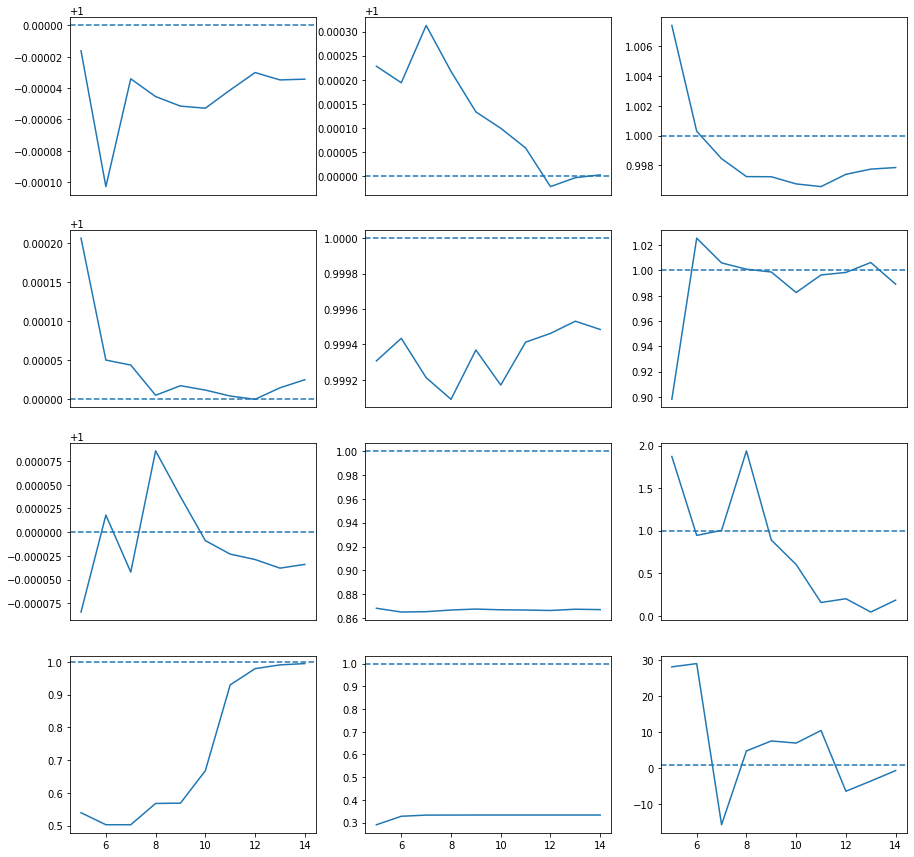

In [187]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = c.loc[(c.func == func) & (c['ndims'] == ndims) & (c['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vflow')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VFlowGPU

In [255]:
# temp_arr = np.load('result/06_Comp_VFlow/f1_run2_fp_d8_means_sdevs.npy')
# compute_variance_weighted_result(temp_arr[0][2:], temp_arr[1][2:])

In [13]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VFlowFinalGPU/f1_run2_fp.csv',
    'f1_run2': 'result/06_Comp_VFlowFinalGPU/f1_run3_fp.csv',
        
    'f2_run1': 'result/06_Comp_VFlowFinalGPU/f2_run1_fp.csv',
    'f2_run2': 'result/06_Comp_VFlowFinalGPU/f2_run2_fp.csv',
    'f2_run3': 'result/06_Comp_VFlowFinalGPU/f2_run3_fp.csv',
    
    'f3_run1': 'result/06_Comp_VFlowFinalGPU/f3_run1_fp.csv',
    'f3_run2': 'result/06_Comp_VFlowFinalGPU/f3_run2_fp.csv',
    'f3_run3': 'result/06_Comp_VFlowFinalGPU/f3_run3_fp.csv',
}

In [14]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [15]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,20000000,0.999954,0.000085,0.542597,49.508,18.419,5.066460,0.828477,2
1,f1,6,15,20000000,0.999958,0.000053,0.792133,37.002,12.377,6.944585,0.642889,2
2,f1,4,15,20000000,0.999986,0.000041,0.342570,27.644,9.288,3.852455,0.920852,2
3,f1,2,15,20000000,1.000012,0.000028,0.446491,15.890,5.355,10.310619,0.325929,2
0,f1,8,15,20000000,0.999974,0.000081,0.319953,49.347,18.214,5.679718,0.771496,3
1,f1,6,15,20000000,0.999967,0.000053,0.628815,37.090,12.394,9.896406,0.358937,3
2,f1,4,15,20000000,0.999956,0.000041,1.063826,27.579,9.258,6.186632,0.721104,3
3,f1,2,15,20000000,1.000016,0.000028,0.586685,15.895,5.354,9.174817,0.421296,3
0,f2,8,15,20000000,0.333326,0.000026,25988.762286,51.536,19.266,7.519446,0.583202,1
1,f2,6,15,20000000,1.001282,0.001950,0.657468,38.533,12.929,17.091601,0.047301,1


In [16]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   20000000   1.000014   0.000003   0.000028  1.261339e-09   
     4    15   20000000   0.999971   0.000021   0.000041  7.474250e-09   
     6    15   20000000   0.999962   0.000006   0.000053  4.849716e-07   
     8    15   20000000   0.999964   0.000014   0.000083  2.666510e-06   
f2   2    15   20000000   0.999908   0.000105   0.000128  4.529086e-09   
     4    15   20000000   1.000252   0.000475   0.000517  4.020859e-07   
     6    15   20000000   0.999837   0.001253   0.001926  2.264035e-05   
     8    15   20000000   0.444654   0.192833   0.000360  5.821090e-04   
f3   2    15   20000000   1.000978   0.002773   0.002495  3.688911e-08   
     4    15   20000000   1.004345   0.039950   0.040482  8.710059e-07   
     6    15   20000000   1.240273   1.263599   1.017013  1.755156e-05   
     8    15   20000000 -16.535878  52.713685  36.663618  2.979361e-04   

                              res_rel               total_time            \
                                 mean           std       mean       std   
func ndim nitn neval                                                       
f1   2    15   20000000      0.516588      0.099132  15.892500  0.003536   
     4    15   20000000      0.703198      0.510004  27.611500  0.045962   
     6    15   20000000      0.710474      0.115483  37.046000  0.062225   
     8    15   20000000      0.431275      0.157433  49.427500  0.113844   
f2   2    15   20000000      0.794040      0.709904  15.943000  0.016371   
     4    15   20000000      0.869715      0.256630  27.643667  0.022030   
     6    15   20000000      0.527655      0.116781  38.595000  0.074054   
     8    15   20000000  18592.624380  15917.891639  51.337333  0.202082   
f3   2    15   20000000      0.945703      0.351565  15.861333  0.004163   
     4    15   20000000      0.779699      0.281559  27.593667  0.019399   
     6    15   20000000      1.013824      0.292733  36.939333  0.120106   
     8    15   20000000      0.940345      1.041143  49.204667  0.139159   

                          pre_time                 chi2                   Q  \
                              mean       std       mean       std      mean   
func ndim nitn neval                                                          
f1   2    15   20000000   5.354500  0.000707   9.742718  0.803133  0.373613   
     4    15   20000000   9.273000  0.021213   5.019544  1.650513  0.820978   
     6    15   20000000  12.385500  0.012021   8.420495  2.087253  0.500913   
     8    15   20000000  18.316500  0.144957   5.373089  0.433639  0.799986   
f2   2    15   20000000   5.398667  0.004041   8.089709  3.598243  0.553361   
     4    15   20000000   9.307333  0.015695   9.237560  5.734498  0.500471   
     6    15   20000000  12.961667  0.061849   9.683724  6.465736  0.508542   
     8    15   20000000  19.162667  0.091697   7.790826  5.692916  0.569008   
f3   2    15   20000000   5.336333  0.006506   7.921875  5.336495  0.522506   
     4    15   20000000   9.253333  0.007572  11.149601  7.917414  0.444601   
     6    15   20000000  12.377667  0.096231  10.255677  1.744467  0.342518   
     8    15   20000000  18.290667  0.090782   6.690916  2.538492  0.663740   

                                   itype  
                              std         
func ndim nitn neval                      
f1   2    15   20000000  0.067435  vflow  
     4    15   20000000  0.141244  vflow  
     6    15   20000000  0.200785  vflow  
     8    15   20000000  0.040291  vflow  
f2   2    15   20000000  0.315620  vflow  
     4    15   20000000  0.412120  vflow  
     6    15   20000000  0.407313  vflow  
     8    15   20000000  0.425378  vflow  
f3   2    15   20000000  0.414431  vflow  
     4    15   20000000  0.423632  vflow  
     6    15   20000000  0.12

#### Plot

In [17]:
temp_folder = 'result/06_Comp_VFlowFinalGPU'

In [18]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [20]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [21]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000087,1.000010,0.999856,0.999986,0.999871,1.000010,0.999966,0.999911,1.000063,0.999982,1
1,f1,2,sdev,0.000137,0.000110,0.000094,0.000085,0.000081,0.000080,0.000080,0.000082,0.000083,0.000085,1
0,f1,4,mean,0.999912,0.999801,0.999911,0.999682,0.999867,0.999925,1.000134,0.999966,1.000033,0.999767,1
1,f1,4,sdev,0.000209,0.000163,0.000138,0.000125,0.000119,0.000117,0.000117,0.000119,0.000122,0.000124,1
0,f1,6,mean,0.999613,1.000215,1.000060,1.000179,0.999777,1.000027,0.999962,0.999988,0.999782,0.999960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.128015,0.128039,0.128030,0.127999,0.128015,0.128003,0.128020,0.128016,0.128030,0.128029,3
0,f3,6,mean,-0.704749,-4.348436,5.650446,-1.597537,7.086666,-1.865893,0.838777,-1.955420,-3.468705,-1.499213,3
1,f3,6,sdev,3.215834,3.216122,3.215713,3.216247,3.216035,3.215812,3.216202,3.215870,3.216503,3.216252,3
0,f3,8,mean,-143.351929,-213.140190,27.184795,57.640657,-85.015169,-14.155692,173.464506,116.490195,11.042057,63.326653,3


In [22]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000044,0.999940,0.999919,1.000004,0.999934,1.000009,1.000059,0.999999,1.000016,1.000049
1,f1,2,sdev,0.000137,0.000110,0.000094,0.000085,0.000081,0.000080,0.000080,0.000082,0.000083,0.000085
2,f1,4,mean,0.999952,0.999978,1.000027,0.999903,0.999875,0.999957,1.000001,1.000039,0.999904,0.999885
3,f1,4,sdev,0.000210,0.000163,0.000138,0.000125,0.000118,0.000116,0.000117,0.000119,0.000122,0.000125
4,f1,6,mean,0.999812,1.000154,0.999912,0.999933,0.999974,0.999939,1.000007,0.999845,1.000055,0.999982
5,f1,6,sdev,0.000281,0.000213,0.000178,0.000160,0.000152,0.000150,0.000151,0.000154,0.000157,0.000160
6,f1,8,mean,0.997226,1.000467,1.000265,1.000486,1.000011,0.999832,0.999935,0.999987,0.999977,1.000005
7,f1,8,sdev,0.009122,0.001563,0.000651,0.000397,0.000289,0.000234,0.000204,0.000191,0.000186,0.000187
8,f2,2,mean,1.000005,0.999647,1.000068,0.999777,1.000068,0.999879,1.000286,0.999715,0.999816,0.999818
9,f2,2,sdev,0.000457,0.000425,0.000408,0.000399,0.000394,0.000393,0.000393,0.000393,0.000395,0.000396


In [23]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

c = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
c

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000044,0.999981,0.999952,0.999971,0.999960,0.999971,0.999987,0.999989,0.999992,0.999999
1,f1,2,sdev,0.000137,0.000086,0.000063,0.000051,0.000043,0.000038,0.000034,0.000032,0.000030,0.000028
2,f1,4,mean,0.999952,0.999969,0.999996,0.999962,0.999937,0.999942,0.999953,0.999966,0.999958,0.999950
3,f1,4,sdev,0.000210,0.000129,0.000094,0.000075,0.000063,0.000056,0.000050,0.000046,0.000043,0.000041
4,f1,6,mean,0.999812,1.000029,0.999973,0.999959,0.999963,0.999958,0.999967,0.999948,0.999962,0.999964
5,f1,6,sdev,0.000281,0.000170,0.000123,0.000097,0.000082,0.000072,0.000065,0.000060,0.000056,0.000053
6,f1,8,mean,0.997226,1.000374,1.000282,1.000423,1.000189,1.000023,0.999990,0.999989,0.999986,0.999990
7,f1,8,sdev,0.009122,0.001541,0.000599,0.000331,0.000218,0.000159,0.000126,0.000105,0.000091,0.000082
8,f2,2,mean,1.000005,0.999813,0.999907,0.999871,0.999914,0.999908,0.999966,0.999933,0.999919,0.999909
9,f2,2,sdev,0.000457,0.000311,0.000247,0.000210,0.000186,0.000168,0.000154,0.000144,0.000135,0.000128


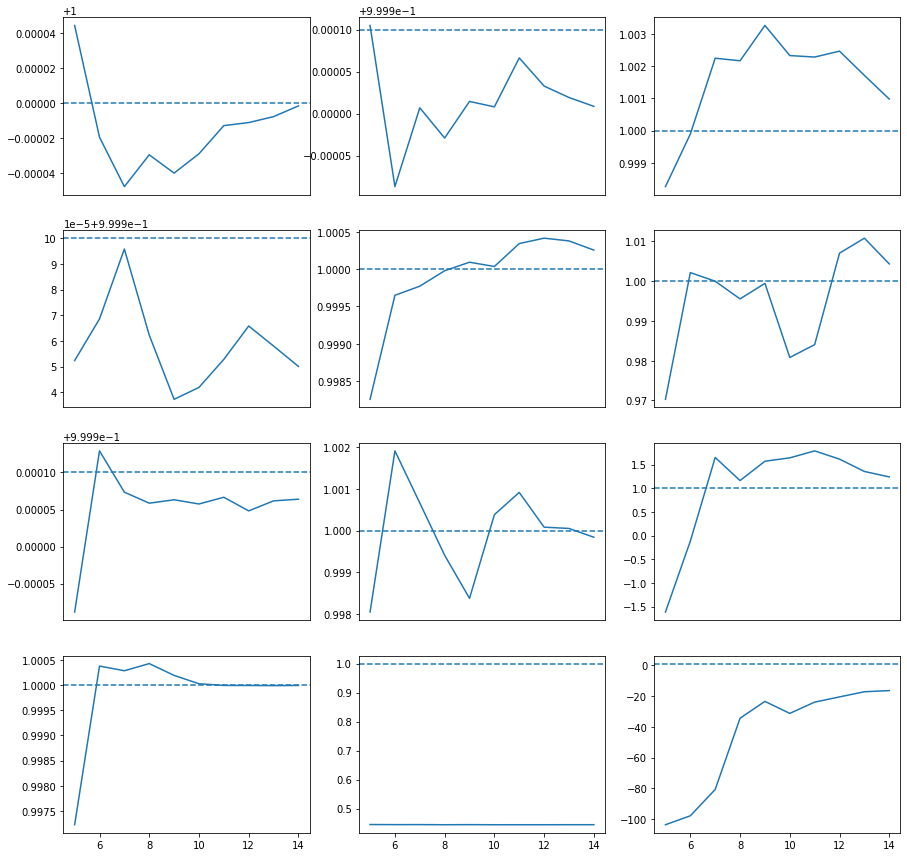

In [25]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = c.loc[(c.func == func) & (c['ndims'] == ndims) & (c['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vflow')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VFlowGPUSame

In [212]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VFlowGPUSame/f1_run1_fp.csv',
    'f1_run2': 'result/06_Comp_VFlowGPUSame/f1_run2_fp.csv',
    'f1_run3': 'result/06_Comp_VFlowGPUSame/f1_run3_fp.csv',
        
    'f2_run1': 'result/06_Comp_VFlowGPUSame/f2_run1_fp.csv',
    'f2_run2': 'result/06_Comp_VFlowGPUSame/f2_run2_fp.csv',
    'f2_run3': 'result/06_Comp_VFlowGPUSame/f2_run3_fp.csv',
    
    'f3_run1': 'result/06_Comp_VFlowGPUSame/f3_run1_fp.csv',
    'f3_run2': 'result/06_Comp_VFlowGPUSame/f3_run2_fp.csv',
    'f3_run3': 'result/06_Comp_VFlowGPUSame/f3_run3_fp.csv',
}

In [213]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [214]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,10000000,1.065498e-01,4.922382e-05,1.815077e+04,27.538,11.095,3.925941e+07,0.000000,1
1,f1,6,15,10000000,9.999971e-01,7.503201e-05,3.873166e-02,19.274,6.455,4.581735e+00,0.869141,1
2,f1,4,15,10000000,9.999887e-01,5.791487e-05,1.958547e-01,14.434,4.878,3.550280e+00,0.938448,1
3,f1,2,15,10000000,9.999869e-01,3.950030e-05,3.307046e-01,8.290,2.828,7.554798e+00,0.579557,1
0,f1,8,15,10000000,1.450997e-09,1.386689e-09,7.211423e+08,27.116,10.965,3.343642e+07,0.000000,2
1,f1,6,15,10000000,1.000001e+00,7.586090e-05,1.661407e-02,19.471,6.569,1.288301e+01,0.167972,2
2,f1,4,15,10000000,9.999452e-01,5.792872e-05,9.461336e-01,14.429,4.868,6.033747e+00,0.736536,2
3,f1,2,15,10000000,9.999358e-01,3.947722e-05,1.627488e+00,8.272,2.815,4.994474e+00,0.834790,2
0,f1,8,15,10000000,9.999834e-01,1.314398e-04,1.260216e-01,26.891,10.734,1.387507e+01,0.126839,3
1,f1,6,15,10000000,1.000063e+00,7.492832e-05,8.452817e-01,19.211,6.490,1.585571e+01,0.069956,3


In [215]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   10000000   0.999968   0.000028   0.000039  1.277900e-08   
     4    15   10000000   0.999991   0.000047   0.000058  1.731972e-08   
     6    15   10000000   1.000021   0.000037   0.000075  5.111289e-07   
     8    15   10000000   0.368844   0.549173   0.000060  6.640581e-05   
f2   2    15   10000000   0.999964   0.000052   0.000181  4.411671e-09   
     4    15   10000000   0.999399   0.000424   0.000731  5.801128e-07   
     6    15   10000000   0.777734   0.192582   0.001293  1.242778e-03   
     8    15   10000000   0.333324   0.000031   0.000039  4.736395e-06   
f3   2    15   10000000   0.996876   0.002221   0.003529  3.691230e-08   
     4    15   10000000   0.966170   0.068468   0.057251  1.973733e-06   
     6    15   10000000   1.433280   1.464139   1.438205  1.765714e-05   
     8    15   10000000 -20.011496  11.605103  51.849966  2.393217e-03   

                              res_rel               total_time            \
                                 mean           std       mean       std   
func ndim nitn neval                                                       
f1   2    15   10000000  8.175511e-01  7.061886e-01   8.277000  0.011358   
     4    15   10000000  6.039674e-01  3.794619e-01  14.420000  0.020075   
     6    15   10000000  3.002091e-01  4.721762e-01  19.318667  0.135633   
     8    15   10000000  2.403868e+08  4.163465e+08  27.181667  0.328461   
f2   2    15   10000000  2.300602e-01  2.499739e-01   8.322333  0.014012   
     4    15   10000000  8.219250e-01  5.809192e-01  14.445667  0.011240   
     6    15   10000000  3.863178e+02  3.346423e+02  20.287000  0.182978   
     8    15   10000000  1.717602e+04  2.032894e+03  28.199000  0.103116   
f3   2    15   10000000  8.852114e-01  6.295116e-01   8.252000  0.010817   
     4    15   10000000  1.008359e+00  6.548603e-01  14.401333  0.015885   
     6    15   10000000  7.422550e-01  5.883360e-01  19.397667  0.025658   
     8    15   10000000  4.052354e-01  2.238241e-01  27.097000  0.142790   

                          pre_time                    chi2                \
                              mean       std          mean           std   
func ndim nitn neval                                                       
f1   2    15   10000000   2.819000  0.007810  7.156878e+00  1.993455e+00   
     4    15   10000000   4.869000  0.008544  5.581058e+00  1.846531e+00   
     6    15   10000000   6.504667  0.058398  1.110682e+01  5.843098e+00   
     8    15   10000000  10.931333  0.182840  2.423195e+07  2.118648e+07   
f2   2    15   10000000   2.861333  0.010116  9.046853e+00  4.096481e+00   
     4    15   10000000   4.908000  0.004583  1.186065e+01  5.756661e+00   
     6    15   10000000   6.858333  0.034530  5.837369e+00  1.921089e+00   
     8    15   10000000  11.286333  0.126950  5.880009e+00  1.428095e+00   
f3   2    15   10000000   2.798333  0.004041  1.180885e+01  4.141811e+00   
     4    15   10000000   4.853000  0.001732  1.497031e+01  5.627205e+00   
     6    15   10000000   6.530000  0.015716  7.383519e+00  3.477944e+00   
     8    15   10000000  10.828333  0.073793  1.012508e+01  2.874148e+00   

                                Q            itype  
                             mean       std         
func ndim nitn neval                                
f1   2    15   10000000  0.619637  0.198176  vflow  
     4    15   10000000  0.765179  0.160871  vflow  
     6    15   10000000  0.369023  0.435878  vflow  
     8    15   10000000  0.042280  0.073231  vflow  
f2   2    15   10000000  0.462211  0.369854  vflow  
     4    15   10000000  0.330188  0.359560  vflow  
     6    15   10000000  0.746858  0.187505  vflow  
     8    15   10000000  0.745391  0.137191  vflow  
f3   2    15   10000000  0.288368  0.299274  vflow

### IFlow

In [6]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_IFlow/f1_run1_fp.csv',
#     'f1_run2': 'result/06_Comp_IFlow/f1_run3_fp',
#     'f1_run3': 'result/06_Comp_IFlow/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_IFlow/f2_run1_fp.csv',
#     'f2_run2': 'result/06_Comp_IFlow/f2_run2_fp',
#     'f2_run3': 'result/06_Comp_IFlow/f2_run3_fp',
    
    'f3_run1': 'result/06_Comp_IFlow/f3_run1_fp.csv',
#     'f3_run2': 'result/06_Comp_IFlow/f3_run2_fp',
#     'f3_run3': 'result/06_Comp_IFlow/f3_run3_fp',
}

In [7]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [8]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,100000,3.745974e-58,2.814935e-58,3.552479e+57,125.371,49.810,8.636211,0.471509,1
1,f1,6,15,100000,1.988522e-30,1.979082e-30,5.052848e+29,98.511,39.809,10.053716,0.346154,1
2,f1,4,15,100000,2.075346e-02,1.083659e-02,9.036480e+01,48.266,20.316,10.022733,0.348648,1
3,f1,2,15,100000,1.004032e+00,2.682569e-02,1.503021e-01,15.853,7.287,2.267741,0.986492,1
0,f2,8,15,100000,7.047712e-77,6.288672e-77,1.590161e+76,124.699,48.696,9.965648,0.353273,1
1,f2,6,15,100000,4.600936e-18,4.190311e-18,2.386457e+17,98.630,39.656,8.830572,0.453059,1
2,f2,4,15,100000,2.103890e-02,8.095076e-03,1.209329e+02,48.765,20.513,17.566032,0.040555,1
3,f2,2,15,100000,1.021300e+00,1.486447e-02,1.432931e+00,15.877,7.282,11.395301,0.249583,1
0,f3,8,15,100000,4.668949e+05,2.262108e+02,2.063977e+03,126.303,49.083,3.571101,0.937312,1
1,f3,6,15,100000,1.295542e+04,6.272339e+00,2.065325e+03,99.992,40.245,6.996641,0.637469,1


In [10]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg(np.mean,)\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'iflow'
agg_df.drop(['res_rel', 'pre_time', 'chi2', 'Q', 'itype'],axis=1).round(6)

,func,ndim,nitn,neval,res_mean,res_err,total_time
0,f1,2,15,100000,1.004032,0.026826,15.853
1,f1,4,15,100000,0.020753,0.010837,48.266
2,f1,6,15,100000,0.000000,0.000000,98.511
3,f1,8,15,100000,0.000000,0.000000,125.371
4,f2,2,15,100000,1.021300,0.014864,15.877
5,f2,4,15,100000,0.021039,0.008095,48.765
6,f2,6,15,100000,0.000000,0.000000,98.630
7,f2,8,15,100000,0.000000,0.000000,124.699
8,f3,2,15,100000,31.795753,0.015309,15.993
9,f3,4,15,100000,515.283905,0.249528,48.943


### General Convergence Plot

In [ ]:
# a, b, c

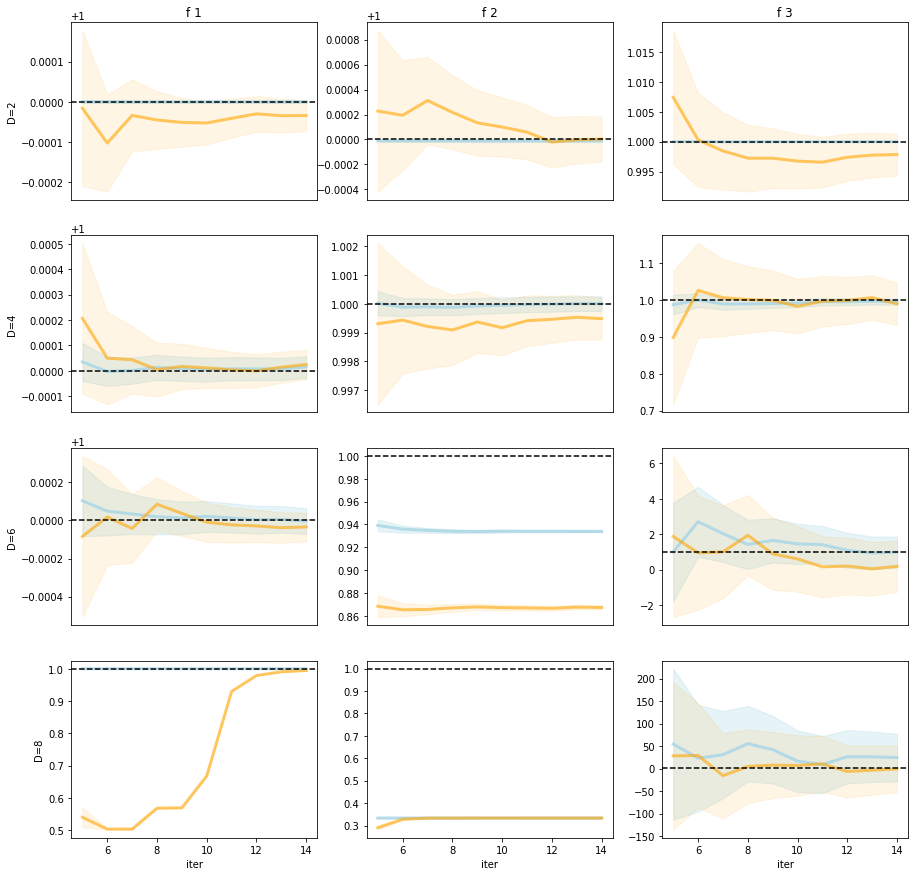

In [236]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy_sobol = a.loc[(a.func == func)
                              & (a['ndims'] == ndims)
                              & (a['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_sobol_sigma = a.loc[(a.func == func)
                                    & (a['ndims'] == ndims)
                                    & (a['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        temp_yy_vegas = b.loc[(b.func == func)
                              & (b['ndims'] == ndims)
                              & (b['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_vegas_sigma = b.loc[(b.func == func)
                                    & (b['ndims'] == ndims)
                                    & (b['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        temp_yy_vflow = c.loc[(c.func == func)
                              & (c['ndims'] == ndims)
                              & (c['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_vflow_sigma = c.loc[(c.func == func)
                                    & (c['ndims'] == ndims)
                                    & (c['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        
        # ax.plot(temp_xx, temp_yy_sobol, label='sobol', color='blue')
        ax.plot(temp_xx, temp_yy_vegas, label='vegas', color='lightblue', linewidth=3, alpha=0.9)
        ax.fill_between(temp_xx,
                        temp_yy_vegas-temp_yy_vegas_sigma,
                        temp_yy_vegas+temp_yy_vegas_sigma,
                        color='lightblue',
                        alpha=.3)
        
        ax.plot(temp_xx, temp_yy_vflow, label='vflow', color='orange', linewidth=3, alpha=0.6)
        ax.fill_between(temp_xx,
                        temp_yy_vflow-temp_yy_vflow_sigma,
                        temp_yy_vflow+temp_yy_vflow_sigma,
                        color='orange',
                        alpha=.1)
        
        
        ax.axhline(1, linestyle='--', color='black')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])
        else:
            ax.set_xlabel('iter')
        if i == 0:
            ax.set_title(f'f {func[-1]}')
        if j == 0:
            ax.set_ylabel(f'D={ndims}')

In [238]:
fig.savefig('result/06_Comp_Vegas/convergence.png', format='png', bbox_inches='tight')

In [240]:
pd.read_csv('result/06_Comp_VFlowGPUSame/f1_run1_fp.csv').sort_values(['ndim'])

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
3,f1,2,15,10000000,0.999987,0.000040,0.330705,8.290,2.828,7.554798e+00,0.579557,1
2,f1,4,15,10000000,0.999989,0.000058,0.195855,14.434,4.878,3.550280e+00,0.938448,1
1,f1,6,15,10000000,0.999997,0.000075,0.038732,19.274,6.455,4.581735e+00,0.869141,1
0,f1,8,15,10000000,0.106550,0.000049,18150.770038,27.538,11.095,3.925941e+07,0.000000,1
